In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
import sys
from tqdm import tqdm
import psix
import seaborn as sns
from scipy.stats import zscore
from matplotlib.gridspec import GridSpec
import subprocess as sp

cm = 1/2.54

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
psix_object = psix.Psix(psix_object = 'psix_output/psix_object/')

In [3]:
psix_object.get_cell_metric(psix_object.latent)

100%|██████████| 1067/1067 [00:01<00:00, 974.44it/s]

Successfully computed cell-cell metric


In [4]:
meta = pd.read_csv('data/SraRunTable.txt.gz', index_col=0)
neighbors_confusion = pd.DataFrame(np.zeros((6, 6)), 
                                   index = ['embryonic day 13.5', 'embryonic day 15.5', 'embryonic day 18.5',
       'postnatal day 1', 'postnatal day 7', 'postnatal day 90'],
                                  columns = ['embryonic day 13.5', 'embryonic day 15.5', 'embryonic day 18.5',
       'postnatal day 1', 'postnatal day 7', 'postnatal day 90'])

In [5]:
e13 = 0
e15 = 0
e18 = 0
p1 = 0
p7 = 0
p90 = 0

for i in range(psix_object.metric[0].shape[0]):
    
    cell_i = psix_object.latent.iloc[psix_object.metric[0][i]].index[0]
    cell_i_neighbors = psix_object.latent.iloc[psix_object.metric[0][i]].index[1:]
    
    cell_i_type = meta.loc[cell_i].Age
    
    if cell_i_type == 'embryonic day 13.5':
        e13 += 1
    elif cell_i_type == 'embryonic day 15.5':
        e15 += 1
    elif cell_i_type == 'embryonic day 18.5':
        e18 += 1
    elif cell_i_type == 'postnatal day 1':
        p1 += 1
    elif cell_i_type == 'postnatal day 7':
        p7 += 1
    else:
        p90 += 1
    
    neighbors = meta.loc[cell_i_neighbors]
    
    neighbors_confusion.loc[cell_i_type, 'embryonic day 13.5'] += np.mean(meta.loc[cell_i_neighbors].Age == 'embryonic day 13.5')
    neighbors_confusion.loc[cell_i_type, 'embryonic day 15.5'] += np.mean(meta.loc[cell_i_neighbors].Age == 'embryonic day 15.5')
    neighbors_confusion.loc[cell_i_type, 'embryonic day 18.5'] += np.mean(meta.loc[cell_i_neighbors].Age == 'embryonic day 18.5')
    neighbors_confusion.loc[cell_i_type, 'postnatal day 1'] += np.mean(meta.loc[cell_i_neighbors].Age == 'postnatal day 1')
    neighbors_confusion.loc[cell_i_type, 'postnatal day 7'] += np.mean(meta.loc[cell_i_neighbors].Age == 'postnatal day 7')
    neighbors_confusion.loc[cell_i_type, 'postnatal day 90'] += np.mean(meta.loc[cell_i_neighbors].Age == 'postnatal day 90')
    
    
    
#     neighbors_confusion



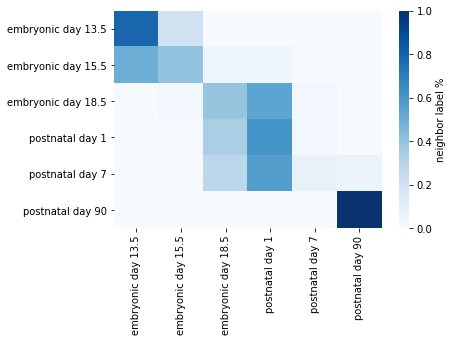

In [6]:
sns.heatmap(
    neighbors_confusion.divide(pd.Series([e13, e15, e18, p1, p7, p90], index = neighbors_confusion.index), axis=0),
    cmap='Blues', vmin=0, vmax=1, cbar_kws={'label': 'neighbor label %'}
)

In [25]:
introns_tab = pd.read_csv('~/psix_project/psix/annotation/mm10_introns.tab.gz', sep='\t', index_col=0)

I1_tab = introns_tab.loc[[x for x in introns_tab.index if x.split('_')[-1] == 'I1']]
I2_tab = introns_tab.loc[[x for x in introns_tab.index if x.split('_')[-1] == 'I2']]

start_se = [int(x.split(':')[1].split('-')[1])+1 for x in I1_tab.intron]
end_se = [int(x.split(':')[1].split('-')[0]) for x in I2_tab.intron]
se_event = list(I1_tab.event)
chrom = [x.split(':')[0] for x in I1_tab.intron]
strand = [x.split(':')[2] for x in I1_tab.intron]

introns_loc = pd.DataFrame(index=se_event)
introns_loc['chrom'] = chrom
introns_loc['start'] = start_se
introns_loc['end'] = end_se
introns_loc['strand'] = strand

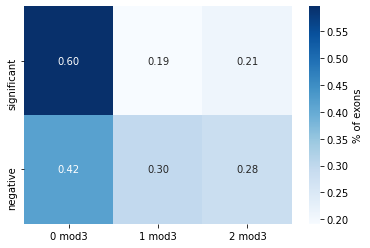

In [26]:
introns_loc_sig = introns_loc.loc[psix_object.psix_results.loc[psix_object.psix_results.qvals <= 0.05].index]
introns_loc_neg = introns_loc.loc[psix_object.psix_results.loc[(psix_object.psix_results.qvals > 0.05)].index]

module_df = pd.DataFrame(np.zeros((2, 3)), 
                         index = ['significant', 'negative'], columns=['0 mod3', '1 mod3', '2 mod3'])


module_df.loc['significant', '0 mod3'] = (((introns_loc_sig.end - introns_loc_sig.start)%3) == 0).mean()
module_df.loc['significant', '1 mod3'] = (((introns_loc_sig.end - introns_loc_sig.start)%3) == 1).mean()
module_df.loc['significant', '2 mod3'] = (((introns_loc_sig.end - introns_loc_sig.start)%3) == 2).mean()

# module_df.loc['positive', '0 mod3'] = (((introns_loc_pos.end - introns_loc_pos.start)%3) == 0).mean()
# module_df.loc['positive', '1 mod3'] = (((introns_loc_pos.end - introns_loc_pos.start)%3) == 1).mean()
# module_df.loc['positive', '2 mod3'] = (((introns_loc_pos.end - introns_loc_pos.start)%3) == 2).mean()

module_df.loc['negative', '0 mod3'] = (((introns_loc_neg.end - introns_loc_neg.start)%3) == 0).mean()
module_df.loc['negative', '1 mod3'] = (((introns_loc_neg.end - introns_loc_neg.start)%3) == 1).mean()
module_df.loc['negative', '2 mod3'] = (((introns_loc_neg.end - introns_loc_neg.start)%3) == 2).mean()

sns.heatmap(module_df, cmap='Blues', annot=True, fmt='.2f', cbar_kws={'label': '% of exons'})

In [37]:
from scipy.stats import hypergeom
from scipy.stats.mstats import zscore
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from statsmodels.stats.multitest import multipletests

def hyper_test(M, n, N, k):
    '''
    Calculates the hypergeometric test.
    
    Input:
      M: Population size (total exons tested)
      n: Successess in population (exons with p-value <= x)
      N: Sample size (exons selected)
      k: Successes in sample (selected exons with p-value <= x)
    Output:
      p_depleted: p-value of depletion from the hypergeometric test
      p_enriched: p-value of enrichment from the hypergeometric test
    '''
    hpd = hypergeom(M, n, N) # Hypergeometric distribution
    p_depleted = hpd.cdf(k)  # Get cummulative distribution up to k
    p_enriched = hpd.sf(k-1) # Survival function up to k-1 (1 - cdf(k-1))
    
    enrichment = (M*k)/(N*n)
    
    return p_depleted, p_enriched, enrichment


In [38]:
hyper_test(2087, 1014, 798, 476)

(1.0, 1.1038059488723606e-15, 1.2276895394304301)

In [32]:
introns_loc_sig = introns_loc.loc[psix_object.psix_results.loc[psix_object.psix_results.qvals <= 0.05].index]
introns_loc_neg = introns_loc.loc[psix_object.psix_results.loc[(psix_object.psix_results.qvals > 0.05)].index]

(((introns_loc_sig.end - introns_loc_sig.start)%3) == 0).sum()


476

In [33]:
((introns_loc.loc[psix_object.psix_results.index].end-introns_loc.loc[psix_object.psix_results.index].start)%3==0).sum()

1014

In [34]:
len(introns_loc_sig)

798

In [35]:
len(psix_object.psix_results.index)

2087

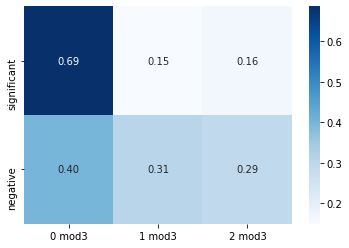

In [267]:
# introns_loc_sig = introns_loc.loc[psix_object.psix_results.loc[psix_object.psix_results.qvals <= 0.05].index]
# introns_loc_neg = introns_loc.loc[psix_object.psix_results.loc[(psix_object.psix_results.qvals > 0.05)].index]

introns_loc_sig = introns_loc.loc[psix_object.psix_results.loc[psix_object.psix_results.psix_score >= 0.1].index]
introns_loc_neg = introns_loc.loc[psix_object.psix_results.loc[(psix_object.psix_results.psix_score < 0)].index]

module_df = pd.DataFrame(np.zeros((2, 3)), 
                         index = ['significant', 'negative'], columns=['0 mod3', '1 mod3', '2 mod3'])


module_df.loc['significant', '0 mod3'] = (((introns_loc_sig.end - introns_loc_sig.start)%3) == 0).mean()
module_df.loc['significant', '1 mod3'] = (((introns_loc_sig.end - introns_loc_sig.start)%3) == 1).mean()
module_df.loc['significant', '2 mod3'] = (((introns_loc_sig.end - introns_loc_sig.start)%3) == 2).mean()

# module_df.loc['positive', '0 mod3'] = (((introns_loc_pos.end - introns_loc_pos.start)%3) == 0).mean()
# module_df.loc['positive', '1 mod3'] = (((introns_loc_pos.end - introns_loc_pos.start)%3) == 1).mean()
# module_df.loc['positive', '2 mod3'] = (((introns_loc_pos.end - introns_loc_pos.start)%3) == 2).mean()

module_df.loc['negative', '0 mod3'] = (((introns_loc_neg.end - introns_loc_neg.start)%3) == 0).mean()
module_df.loc['negative', '1 mod3'] = (((introns_loc_neg.end - introns_loc_neg.start)%3) == 1).mean()
module_df.loc['negative', '2 mod3'] = (((introns_loc_neg.end - introns_loc_neg.start)%3) == 2).mean()

sns.heatmap(module_df, cmap='Blues', annot=True, fmt='.2f')

In [253]:
SE_bed = pd.DataFrame()
SE_bed['chrom'] = chrom
SE_bed['start'] = start_se
SE_bed['end'] = end_se
SE_bed['name'] = se_event

SJ_bed = pd.DataFrame()


chrom_ = []
start_ = []
end_ = []
names_ = []
strand_ = []
assert len(strand) == len(se_event)

for i in tqdm(range(len(se_event)), leave=True, position=0):
    chrom_.extend([chrom[i], chrom[i]])
    start_.append(int(start_se[i])-30)
    start_.append(int(end_se[i])-30)   
    end_.append(int(start_se[i])+30)
    end_.append(int(end_se[i])+30)
    

    if strand[i] == '+':
        names_.append(se_event[i] + '_5p')
        names_.append(se_event[i] + '_3p')
    else:
        names_.append(se_event[i] + '_3p')
        names_.append(se_event[i] + '_5p')
    
    strand_.extend([strand[i], strand[i]])
    
    
SJ_bed['chrom'] = chrom_
SJ_bed['start'] = start_
SJ_bed['end'] = end_

SJ_bed['name'] = names_
SJ_bed['score'] = np.zeros(2*len(se_event))
SJ_bed['strand'] = strand_

100%|██████████| 35732/35732 [00:00<00:00, 238588.24it/s]


In [255]:
if not os.path.isdir('phylop/'):
    os.mkdir('phylop')
    
SE_bed.to_csv('phylop/SE.bed.gz', sep='\t', index=False, header=False)
SJ_bed.to_csv('phylop/SJ.bed.gz', sep='\t', index=False, header=False)

In [256]:
bedtools_cmd = 'bedtools intersect -wb -a ~/Genomes/Mouse/mm10/mm10.60way.phyloP60way.bed.gz -b {bed_file} > {file_phylop}'
print(bedtools_cmd.format(bed_file = 'SJ.bed.gz', file_phylop='SJ_phylop.bed'))
print(bedtools_cmd.format(bed_file = 'SE.bed.gz', file_phylop='SE_phylop.bed'))

sp.run(bedtools_cmd.format(bed_file = 'phylop/SE.bed.gz', file_phylop='phylop/SE_phylop.bed'), shell=True)
sp.run(bedtools_cmd.format(bed_file = 'phylop/SJ.bed.gz', file_phylop='phylop/SJ_phylop.bed'), shell=True)

bedtools intersect -wb -a ~/Genomes/Mouse/mm10/mm10.60way.phyloP60way.bed.gz -b SJ.bed.gz > SJ_phylop.bed
bedtools intersect -wb -a ~/Genomes/Mouse/mm10/mm10.60way.phyloP60way.bed.gz -b SE.bed.gz > SE_phylop.bed


In [6]:
SE_phylop = pd.read_csv('phylop/SJ_phylop.bed.gz', names=['chrom', 'bp_start', 'bp_end', 'phylop_id', 'score',
                                                         'chrom_', 'exon_start', 'exon_end', 'exon_name', 'score_',
                                                      'strand'], sep='\t')

In [7]:
exon_phylop = SE_phylop.groupby('exon_name').score.mean()

In [18]:
sig_exons = psix_object.psix_results.loc[psix_object.psix_results.qvals <= 0.05].index
sig_exons_5p = exon_phylop.index.intersection(pd.Index([x + '_5p' for x in sig_exons]))
sig_exons_3p = exon_phylop.index.intersection(pd.Index([x + '_3p' for x in sig_exons]))

neg_exons = psix_object.psix_results.loc[(psix_object.psix_results.qvals > 0.05)].index
neg_exons_5p = exon_phylop.index.intersection(pd.Index([x + '_5p' for x in neg_exons]))
neg_exons_3p = exon_phylop.index.intersection(pd.Index([x + '_3p' for x in neg_exons]))

In [23]:
exon_phylop.loc[sig_exons_5p|sig_exons_3p].median()

2.26515

In [24]:
exon_phylop.loc[neg_exons_5p|neg_exons_3p].median()

1.7201499999999998

In [20]:
ranksums(exon_phylop.loc[sig_exons_5p|sig_exons_3p],
         exon_phylop.loc[neg_exons_5p|neg_exons_3p])

RanksumsResult(statistic=13.755057280439685, pvalue=4.7490443495833115e-43)

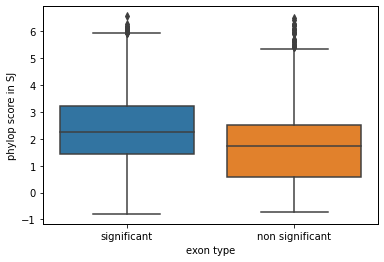

In [14]:
exon_phylop.loc[neg_exons_5p|neg_exons_3p]
scores_df = pd.DataFrame()
scores_df['exon type'] = (['significant']*len(list(sig_exons_5p) + list(sig_exons_3p))) + (['non significant']*len(list(neg_exons_5p) + list(neg_exons_3p)))

scores_df["phylop score in SJ"] = list(exon_phylop.loc[sig_exons_5p|sig_exons_3p]) + list(exon_phylop.loc[neg_exons_5p|neg_exons_3p])

sns.boxplot(x='exon type', y="phylop score in SJ", data=scores_df)

In [10]:
sig_exons = psix_object.psix_results.loc[psix_object.psix_results.qvals <= 0.05].index
sig_exons_5p = exon_phylop.index.intersection(pd.Index([x + '_5p' for x in sig_exons]))
sig_exons_3p = exon_phylop.index.intersection(pd.Index([x + '_3p' for x in sig_exons]))

pos_exons = psix_object.psix_results.loc[
    (psix_object.psix_results.qvals > 0.05) & (psix_object.psix_results.psix_score > 0)].index

pos_exons_5p = exon_phylop.index.intersection(pd.Index([x + '_5p' for x in pos_exons]))
pos_exons_3p = exon_phylop.index.intersection(pd.Index([x + '_3p' for x in pos_exons]))

neg_exons = psix_object.psix_results.loc[(psix_object.psix_results.psix_score <= 0)].index
neg_exons_5p = exon_phylop.index.intersection(pd.Index([x + '_5p' for x in neg_exons]))
neg_exons_3p = exon_phylop.index.intersection(pd.Index([x + '_3p' for x in neg_exons]))


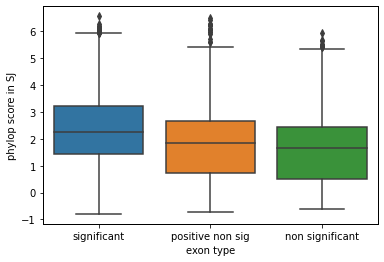

In [11]:
exon_phylop.loc[neg_exons_5p|neg_exons_3p]
scores_df = pd.DataFrame()
scores_df['exon type'] = (['significant']*len(list(sig_exons_5p) + list(sig_exons_3p))) + (['positive non sig']*len(list(pos_exons_5p) + list(pos_exons_3p))) + (['non significant']*len(list(neg_exons_5p) + list(neg_exons_3p)))

scores_df["phylop score in SJ"] = list(exon_phylop.loc[sig_exons_5p|sig_exons_3p]) + list(exon_phylop.loc[pos_exons_5p|pos_exons_3p]) + list(exon_phylop.loc[neg_exons_5p|neg_exons_3p])

sns.boxplot(x='exon type', y="phylop score in SJ", data=scores_df)

In [12]:
from scipy.stats import ranksums, f_oneway

f_oneway(exon_phylop.loc[sig_exons_5p|sig_exons_3p],
         exon_phylop.loc[pos_exons_5p|pos_exons_3p],
         exon_phylop.loc[neg_exons_5p|neg_exons_3p])

F_onewayResult(statistic=109.50175135734759, pvalue=4.514857857658844e-47)

In [11]:
phylop_sig = SE_phylop.loc[SE_phylop.exon_name.isin(sig_exons_5p|sig_exons_3p)]
phylop_pos = SE_phylop.loc[SE_phylop.exon_name.isin(pos_exons_5p|pos_exons_3p)]
phylop_neg = SE_phylop.loc[SE_phylop.exon_name.isin(neg_exons_5p|neg_exons_3p)]

In [12]:
counts_ = 0
suma_ = np.array(np.zeros(120))

for exon in tqdm(neg_exons):
    try:
        slice_exon_5p = phylop_neg.loc[phylop_neg.exon_name == exon + '_5p']
        slice_exon_3p = phylop_neg.loc[phylop_neg.exon_name == exon + '_3p']

        if slice_exon_5p.strand.iloc[0] == '+':
            score_5p = list(slice_exon_5p.score)
            score_3p = list(slice_exon_3p.score)
        else:
            score_5p = list(slice_exon_5p.score)[::-1]
            score_3p = list(slice_exon_3p.score)[::-1]



        suma_ += np.array(score_5p + score_3p)
        counts_ += 1
    except:
        continue

counts = 0
suma = np.array(np.zeros(120))

for exon in tqdm(sig_exons):
    try:
        slice_exon_5p = phylop_sig.loc[phylop_sig.exon_name == exon + '_5p']
        slice_exon_3p = phylop_sig.loc[phylop_sig.exon_name == exon + '_3p']

        if slice_exon_5p.strand.iloc[0] == '+':
            score_5p = list(slice_exon_5p.score)
            score_3p = list(slice_exon_3p.score)
        else:
            score_5p = list(slice_exon_5p.score)[::-1]
            score_3p = list(slice_exon_3p.score)[::-1]



        suma += np.array(score_5p + score_3p)
        counts += 1
    except:
        continue



100%|██████████| 798/798 [00:09<00:00, 82.50it/s]


Text(0, 0.5, 'Average phylop score')

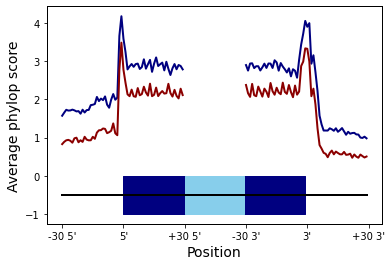

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(list(range(60)), (np.array(suma)/counts)[:60], c='navy', linewidth=2, label='cell state-associated')
plt.plot(list(range(90, 150)), (np.array(suma)/counts)[60:], c='navy', linewidth=2)

plt.plot(list(range(60)), (np.array(suma_)/counts_)[:60], c='darkred', linewidth=2, label='cell state-independent')
plt.plot(list(range(90, 150)), (np.array(suma_)/counts_)[60:], c='darkred', linewidth=2)

plt.plot(range(150), [-0.5]*150, c='black', linewidth=2)

plt.fill_between(range(30, 120), [-1]*90, [0]*90, color='navy')
plt.fill_between(range(60, 90), [-1]*30, [0]*30, color='skyblue')

ax.set_xticks([0, 30, 60, 90, 120, 150])
ax.set_xticklabels(["-30 5'", "5'", "+30 5'", "-30 3'", "3'", "+30 3'"])

plt.xlabel('Position', size=14)
plt.ylabel('Average phylop score', size=14)
# plt.legend(frameon=False)

100%|██████████| 798/798 [00:13<00:00, 60.82it/s]


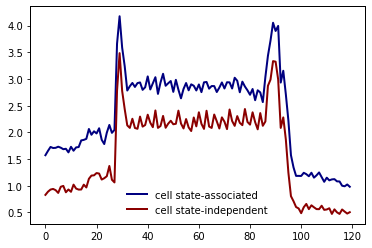

In [204]:
counts_ = 0
suma_ = np.array(np.zeros(120))

for exon in tqdm(neg_exons):
    try:
        slice_exon_5p = phylop_neg.loc[phylop_neg.exon_name == exon + '_5p']
        slice_exon_3p = phylop_neg.loc[phylop_neg.exon_name == exon + '_3p']

        if slice_exon_5p.strand.iloc[0] == '+':
            score_5p = list(slice_exon_5p.score)
            score_3p = list(slice_exon_3p.score)
        else:
            score_5p = list(slice_exon_5p.score)[::-1]
            score_3p = list(slice_exon_3p.score)[::-1]



        suma_ += np.array(score_5p + score_3p)
        counts_ += 1
    except:
        continue

counts = 0
suma = np.array(np.zeros(120))

for exon in tqdm(sig_exons):
    try:
        slice_exon_5p = phylop_sig.loc[phylop_sig.exon_name == exon + '_5p']
        slice_exon_3p = phylop_sig.loc[phylop_sig.exon_name == exon + '_3p']

        if slice_exon_5p.strand.iloc[0] == '+':
            score_5p = list(slice_exon_5p.score)
            score_3p = list(slice_exon_3p.score)
        else:
            score_5p = list(slice_exon_5p.score)[::-1]
            score_3p = list(slice_exon_3p.score)[::-1]



        suma += np.array(score_5p + score_3p)
        counts += 1
    except:
        continue

plt.plot(range(120), np.array(suma)/counts, c='navy', linewidth=2, label='cell state-associated')
plt.plot(range(120), np.array(suma_)/counts_, c='darkred', linewidth=2, label='cell state-independent')
plt.legend(frameon=False)

# Expression modules

In [5]:
norm_tpm = pd.read_csv('data/preprocess/scone_norm_tpm.tab.gz', sep='\t', index_col=0)[psix_object.latent.index]

In [42]:
mod1_genes = zscore(norm_tpm.loc[set([x.split('_')[0] for x in psix_object.modules.loc[psix_object.modules == 1].index])], 
                    axis=1).mean(axis=0)

In [43]:
def plot_module_genes(mod):
    
    genes = pd.Index(set([x.split('_')[0] for x in psix_object.modules.loc[psix_object.modules == mod].index]))
    
    
    
    mod1_genes = norm_tpm.index.intersection(genes)

    mod1_genes = zscore(expression_avg.loc[mod1_genes], axis=1).mean(axis=0)


    plt.tight_layout()
    fig = plt.figure(figsize=(9*cm, 6.25*cm))
    ax = fig.add_subplot(111, projection='3d')

    ax.grid(False)
    sc = ax.scatter(psix_object.latent.PC_1, psix_object.latent.PC_2, psix_object.latent.PC_3,
               c=mod1_genes, s=10, linewidth=0, alpha=0.8, cmap='inferno', vmin=-1, vmax=1)
    ax.set_yticks([-10, -5, 0, 5, 10])
    cb = plt.colorbar(sc, shrink = 0.5, aspect=5)
    cb.set_label(label='expression zscore',size=12)
    cb.ax.tick_params(labelsize=8, length=2)

    cb.outline.set_visible(False)
#     ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
#     ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
#     ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
#     ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.set_xlabel('PC 1', fontsize=12,labelpad=-10)
    ax.set_ylabel('PC 2', fontsize=12,labelpad=-10)
    ax.set_zlabel('PC 3', fontsize=12,labelpad=-12, rotation=90)
    ax.set_title('Module '+str(mod), fontsize=12)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    
    plt.savefig('plots/exon_gene_expression_module_' + str(mod)+'.png', bbox_inches='tight', res=20000, dpi =2000)
    plt.show()

In [44]:
def get_exon_neighbors_psi(observed_psi_array, cell_metric):
    psi_a_array = []
    for i in range(len(observed_psi_array)):

        neighbors = cell_metric[0][i]
        weights = cell_metric[1][i]

        psi_sum = 0
        weight_sum = 0
        for j in range(len(neighbors)):
            psi_n = observed_psi_array[neighbors[j]]
#             print(psi_n)
            if not np.isnan(psi_n):
                psi_sum += (psi_n * weights[j])
                weight_sum += weights[j]
        if weight_sum > 0:
            psi_a_array.append(psi_sum/weight_sum)
        else:
            psi_a_array.append(np.nan)
                
    return psi_a_array


def get_all_exons_neighbors(psi, cell_metric):
    
    neighbors_psi = []
    
    for exon_psi in psi.T:
        neighbors_psi.append(get_exon_neighbors_psi(exon_psi, cell_metric))
        
    return np.array(neighbors_psi)


def get_background(self):
    psi = np.array(self.adata.uns['psi'])
    
    neighbors_psi = pd.DataFrame(get_all_exons_neighbors(psi, self.metric),
                                 columns = self.adata.uns['psi'].index,
                                 index = self.adata.uns['psi'].columns)
    self.adata.uns['neighbors_psi'] = neighbors_psi.T
    

In [126]:
module_genes = norm_tpm.index.intersection(
    pd.Index(set([x.split('_')[0] for x in psix_object.modules.index]))
)

In [127]:
expression_avg = get_all_exons_neighbors(
    np.array(norm_tpm.loc[module_genes, 
                          psix_object.latent.index].T), 
    psix_object.metric
)

In [128]:
expression_avg = pd.DataFrame(expression_avg, index = module_genes, columns = psix_object.latent.index)

<Figure size 432x288 with 0 Axes>

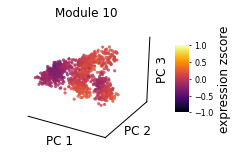

In [129]:
plot_module_genes(10)

<Figure size 432x288 with 0 Axes>

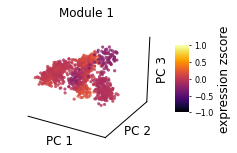

<Figure size 432x288 with 0 Axes>

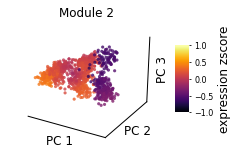

<Figure size 432x288 with 0 Axes>

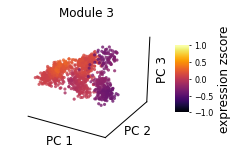

<Figure size 432x288 with 0 Axes>

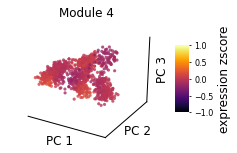

<Figure size 432x288 with 0 Axes>

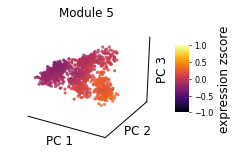

<Figure size 432x288 with 0 Axes>

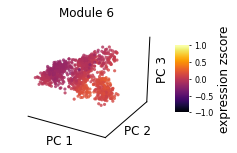

<Figure size 432x288 with 0 Axes>

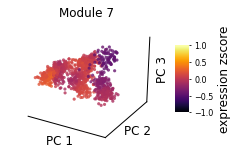

<Figure size 432x288 with 0 Axes>

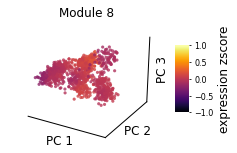

<Figure size 432x288 with 0 Axes>

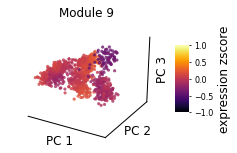

<Figure size 432x288 with 0 Axes>

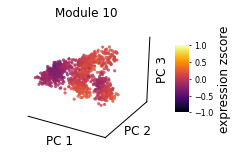

In [130]:
import os
#os.mkdir('plots')
for i in range(1, 11):
    plot_module_genes(i)

In [45]:
DS_exons = psix_object.psix_results.loc[psix_object.psix_results.qvals <= 0.05].index
DS_genes = sorted(set([x.split('_')[0] for x in DS_exons]))

DE_genes = ATres.loc[(ATres.FDR <= 0.05) & (ATres.meanLogFC >= 0.25)].index
DE_exons = isDE.loc[isDE.DE].index

In [74]:
DS_exons = psix_object.psix_results.loc[psix_object.psix_results.qvals <= 0.05].index#.intersection(idx)
DE_exons = isDE.loc[isDE.DE].index.intersection(psix_object.psix_results.index)

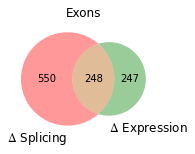

In [81]:
from matplotlib_venn import venn2

fig = plt.figure(figsize=(8*cm, 5.25*cm))

set1 = set(DS_exons)
set2 = set(DE_exons)

v = venn2([set1, set2], ['$\Delta$ Splicing', '$\Delta$ Expression'])

# for text in v.set_labels:
#     text.set_fontsize(8)
# for text in v.subset_labels:
#     text.set_fontsize(8)

plt.title('Exons')

plt.savefig('plots/exons_venn_diagram.png', bbox_inches='tight', res=20000, dpi =2000)


In [6]:
def plot_exon(exon):
    
    plt.tight_layout()
    fig = plt.figure(figsize=(8*cm, 6.25*cm))
    ax = fig.add_subplot(111, projection='3d')

    ax.grid(False)
    sc = ax.scatter(psix_object.latent.PC_1, psix_object.latent.PC_2, psix_object.latent.PC_3,
               c=psix_object.adata.uns['psi'][exon], s=10, linewidth=0, alpha=0.8, cmap='viridis', vmin=0, vmax=1)
    ax.set_yticks([-10, -5, 0, 5, 10])
#     cb = plt.colorbar(sc, shrink = 0.5, aspect=5)
#     cb.set_label(label=r'$\Psi$',size=12)
#     cb.ax.tick_params(labelsize=8, length=2)

#     cb.outline.set_visible(False)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.set_xlabel('PC 1', fontsize=12,labelpad=-10)
    ax.set_ylabel('PC 2', fontsize=12,labelpad=-10)
    ax.set_zlabel('PC 3', fontsize=12,labelpad=-12, rotation=90)
    ax.set_title(exon, fontsize=12)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    plt.savefig('plots/' + str(exon)+'_exon.png', bbox_inches='tight', res=20000, dpi =2000)

    
def plot_gene(exon):
    
    plt.tight_layout()
    fig = plt.figure(figsize=(8*cm, 6.25*cm))
    ax = fig.add_subplot(111, projection='3d')

    ax.grid(False)
    sc = ax.scatter(psix_object.latent.PC_1, psix_object.latent.PC_2, psix_object.latent.PC_3,
               c=norm_tpm.loc[exon.split('_')[0]], s=10, linewidth=0, alpha=0.8, cmap='inferno')
    ax.set_yticks([-10, -5, 0, 5, 10])
#     cb = plt.colorbar(sc, shrink = 0.5, aspect=5)
#     cb.set_label(label='log1p norm expression',size=12)
#     cb.ax.tick_params(labelsize=8, length=2)

#     cb.outline.set_visible(False)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.set_xlabel('PC 1', fontsize=12,labelpad=-10)
    ax.set_ylabel('PC 2', fontsize=12,labelpad=-10)
    ax.set_zlabel('PC 3', fontsize=12,labelpad=-12, rotation=90)
    ax.set_title(exon.split('_')[0], fontsize=12)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    plt.savefig('plots/' + str(exon)+'_gene.png', bbox_inches='tight', res=20000, dpi =2000)

<Figure size 432x288 with 0 Axes>

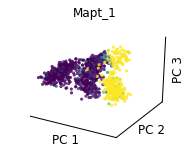

In [58]:
plot_exon('Mapt_1')

<Figure size 432x288 with 0 Axes>

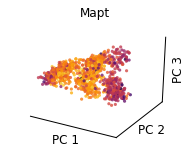

In [59]:
plot_gene('Mapt_1')

<Figure size 432x288 with 0 Axes>

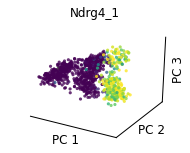

In [60]:
plot_exon('Ndrg4_1')


<Figure size 432x288 with 0 Axes>

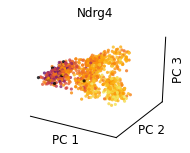

In [61]:
plot_gene('Ndrg4_1')

<Figure size 432x288 with 0 Axes>

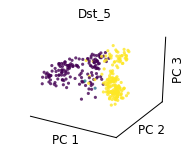

In [62]:
plot_exon('Dst_5')

<Figure size 432x288 with 0 Axes>

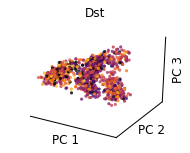

In [63]:
plot_gene('Dst_5')

<Figure size 432x288 with 0 Axes>

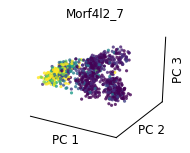

In [64]:
plot_exon('Morf4l2_7')

<Figure size 432x288 with 0 Axes>

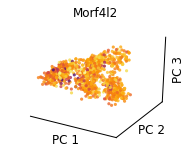

In [65]:
plot_gene('Morf4l2_7')

<Figure size 432x288 with 0 Axes>

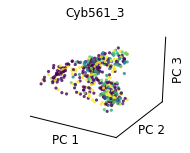

In [66]:
plot_exon('Cyb561_3')

<Figure size 432x288 with 0 Axes>

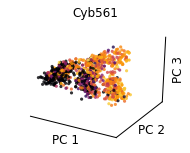

In [67]:
plot_gene('Cyb561_3')

<Figure size 432x288 with 0 Axes>

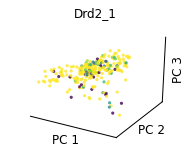

In [68]:
plot_exon('Drd2_1')

<Figure size 432x288 with 0 Axes>

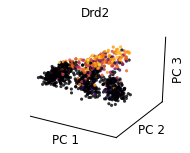

In [69]:
plot_gene('Drd2_1')

<Figure size 432x288 with 0 Axes>

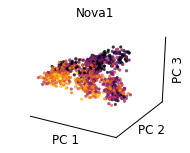

In [7]:
plot_gene('Nova1_1')

<Figure size 432x288 with 0 Axes>

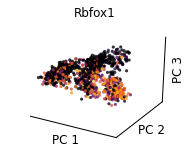

In [8]:
plot_gene('Rbfox1_1')

<Figure size 432x288 with 0 Axes>

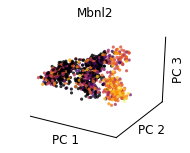

In [9]:
plot_gene('Mbnl2_1')

In [16]:
norm_tpm = pd.read_csv('data/preprocess/scone_norm_tpm_extended.tab.gz', sep='\t', index_col=0)[psix_object.latent.index]

<Figure size 432x288 with 0 Axes>

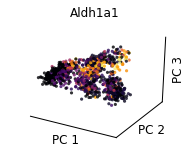

In [17]:
plot_gene('Aldh1a1_1')

<Figure size 432x288 with 0 Axes>

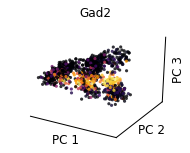

In [18]:
plot_gene('Gad2_1')

<Figure size 432x288 with 0 Axes>

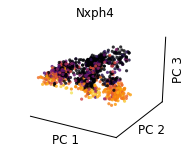

In [19]:
plot_gene('Nxph4_1')

<Figure size 432x288 with 0 Axes>

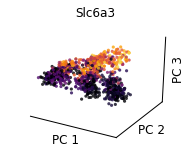

In [20]:
plot_gene('Slc6a3_1')

<Figure size 432x288 with 0 Axes>

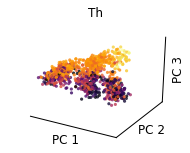

In [21]:
plot_gene('Th_1')

<Figure size 432x288 with 0 Axes>

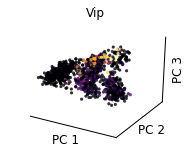

In [22]:
plot_gene('Vip_1')

<Figure size 432x288 with 0 Axes>

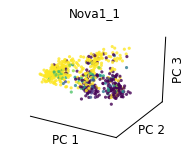

In [73]:
plot_exon('Nova1_1')

In [16]:

def local_correlation_plot(local_correlation_z, modules, linkage,
                           z_cmap='RdBu_r', yticklabels=False,
                           plot_name = ''):
    
    row_colors = None
    colors = list(plt.get_cmap('tab10').colors)
    
    ii = leaves_list(linkage)

    mod_reordered = modules.iloc[ii]
    
    
    col_idx = {}
    
    
    counter = 0
    for i in mod_reordered:
        
        if (i not in col_idx.keys()) and (i != -1):
            col_idx.update({i:counter})
            counter += 1

    module_colors = {i: colors[(col_idx[i]) % len(colors)] for i in col_idx.keys()}
    module_colors[-1] = '#ffffff'

    row_colors1 = pd.Series(
        [module_colors[i] for i in modules],
        index=local_correlation_z.index,
    )

    row_colors = pd.DataFrame({
        "Modules": row_colors1,
    })
    
    
    if plot_name != '':
        figsize = (8/2.4, 9/2.4)
        fontsize = 8
        
    else:
        figsize = (8.4, 9)
        fontsize=20
    
    cm = sns.clustermap(
        local_correlation_z,
        row_linkage=linkage,
        col_linkage=linkage,
        vmin=-1,
        vmax=1,
        cmap=z_cmap,
        xticklabels=False,
        yticklabels=yticklabels,
        row_colors=row_colors,
        rasterized=True,
        figsize=figsize
    )

    fig = plt.gcf()
    plt.sca(cm.ax_heatmap)
    plt.ylabel("")
    plt.xlabel("")

    cm.ax_row_dendrogram.remove()

    mod_map = {}
    y = np.arange(modules.size)

    for x in mod_reordered.unique():
        if x == -1:
            continue

        mod_map[x] = y[mod_reordered == x].mean()

    plt.sca(cm.ax_row_colors)
    
    mod_relabeled = pd.DataFrame()
    mod_idx = []
    mod_labels = []
    i = 1
    for mod, mod_y in mod_map.items():
        
        if int(mod) != -1:
            plt.text(-.25, y=mod_y, s="Mod {}".format(str(i)),
                     horizontalalignment='right',
                     verticalalignment='center', fontsize=fontsize)

            exon_list = list(mod_reordered.loc[mod_reordered == int(mod)].index)
            mod_idx.extend(exon_list)
            mod_labels.extend([i]*len(exon_list))
            i += 1
        
    exon_list = list(mod_reordered.loc[mod_reordered == -1].index)
    mod_idx.extend(exon_list)
    mod_labels.extend([-1]*len(exon_list))
        
    mod_relabeled['Modules'] = mod_labels
    mod_relabeled.index = mod_idx
        
                 
#         plt.text(-.25, y=mod_y, s="Mod {}".format(mod),
#                  horizontalalignment='right',
#                  verticalalignment='center', fontsize=fontsize)
        
    plt.xticks([])

    min_delta = 1e99
    min_aa = None
    for aa in fig.get_children():
        try:
            bbox = aa.get_position()
            delta = (0-bbox.xmin-2)**2 + (1-bbox.ymax)**2
            if delta < min_delta:
                delta = min_delta
                min_aa = aa
        except AttributeError:
            pass

    min_aa.set_ylabel('Pearson r', fontsize=fontsize)
    min_aa.yaxis.set_label_position("left")
    
    min_aa.tick_params(axis='y',labelsize=fontsize, length=0, direction="in", pad=0)
    
    if plot_name == '':
        plt.show()
    else:
        plt.savefig(plot_name, bbox_inches='tight', res=20000, dpi =2000)
    
    return mod_relabeled.Modules#mod_reordered


def sort_linkage(Z, node_index, node_values):
    """
    Sorts linkage by 'node_values' in place
    """

    N = Z.shape[0] + 1  # number of leaves

    if node_index < 0:
        return

    left_child = int(Z[node_index, 0] - N)
    right_child = int(Z[node_index, 1] - N)

    swap = False

    if left_child < 0 and right_child < 0:
        swap = False
    elif left_child < 0 and right_child >= 0:
        swap = True
    elif left_child >= 0 and right_child < 0:
        swap = False
    else:
        if node_values[left_child] > node_values[right_child]:
            swap = True
        else:
            swap = False

    if swap:
        Z[node_index, 0] = right_child + N
        Z[node_index, 1] = left_child + N

    sort_linkage(Z, left_child, node_values)
    sort_linkage(Z, right_child, node_values)


def calc_mean_dists(Z, node_index, out_mean_dists):
    """
    Calculates the mean density of joins
    for sub-trees underneath each node
    """

    N = Z.shape[0] + 1  # number of leaves

    left_child = int(Z[node_index, 0] - N)
    right_child = int(Z[node_index, 1] - N)

    if left_child < 0:
        left_average = 0
        left_merges = 0
    else:
        left_average, left_merges = calc_mean_dists(
            Z, left_child, out_mean_dists
        )

    if right_child < 0:
        right_average = 0
        right_merges = 0
    else:
        right_average, right_merges = calc_mean_dists(
            Z, right_child, out_mean_dists
        )

    this_height = Z[node_index, 2]
    this_merges = left_merges + right_merges + 1
    this_average = (
        left_average * left_merges + right_average * right_merges + this_height
    ) / this_merges

    out_mean_dists[node_index] = this_average

    return this_average, this_merges


def prop_label(Z, node_index, label, labels, out_clusters):
    """
    Propagates node labels downward if they are not -1
    Used to find the correct cluster label at the leaves
    """

    N = Z.shape[0] + 1  # number of leaves

    if label == -1:
        label = labels[node_index]

    left_child = int(Z[node_index, 0] - N)
    right_child = int(Z[node_index, 1] - N)

    if left_child < 0:
        out_clusters[left_child + N] = label
    else:
        prop_label(Z, left_child, label, labels, out_clusters)

    if right_child < 0:
        out_clusters[right_child + N] = label
    else:
        prop_label(Z, right_child, label, labels, out_clusters)


def prop_label2(Z, node_index, label, labels, out_clusters):
    """
    Propagates node labels downward
    Helper method used in assign_modules
    """

    N = Z.shape[0] + 1  # number of leaves

    parent_label = label
    this_label = labels[node_index]

    if this_label == -1:
        new_label = parent_label
    else:
        new_label = this_label

    left_child = int(Z[node_index, 0] - N)
    right_child = int(Z[node_index, 1] - N)

    if left_child < 0:
        out_clusters[left_child + N] = new_label
    else:
        prop_label2(Z, left_child, new_label, labels, out_clusters)

    if right_child < 0:
        out_clusters[right_child + N] = new_label
    else:
        prop_label2(Z, right_child, new_label, labels, out_clusters)


def assign_modules(Z, leaf_labels, offset, MIN_THRESHOLD=10, Z_THRESHOLD=3):
    clust_i = 0

    labels = np.ones(Z.shape[0])*-1
    N = Z.shape[0]+1

    mean_dists = np.zeros(Z.shape[0])
    calc_mean_dists(Z, Z.shape[0]-1, mean_dists)

    for i in range(Z.shape[0]):

        ca = int(Z[i, 0])
        cb = int(Z[i, 1])

        if ca - N < 0:  # leaf node
            n_members_a = 1
            clust_a = -1
        else:
            n_members_a = Z[ca-N, 3]
            clust_a = labels[ca-N]

        if cb - N < 0:  # leaf node
            n_members_b = 1
            clust_b = -1
        else:
            n_members_b = Z[cb-N, 3]
            clust_b = labels[cb-N]

        if Z[i, 2] > offset - Z_THRESHOLD:
            new_clust_assign = -1
        elif (n_members_a >= MIN_THRESHOLD and n_members_b >= MIN_THRESHOLD):
            # don't join them
            # assign the one with the larger mean distance
            dist_a = mean_dists[ca-N]
            dist_b = mean_dists[cb-N]
            if dist_a >= dist_b:
                new_clust_assign = clust_a
            else:
                new_clust_assign = clust_b
        elif n_members_a >= MIN_THRESHOLD:
            new_clust_assign = clust_a
        elif n_members_b >= MIN_THRESHOLD:
            new_clust_assign = clust_b
        elif (n_members_b + n_members_a) >= MIN_THRESHOLD:
            # A new cluster is born!
            new_clust_assign = clust_i
            clust_i += 1
        else:
            new_clust_assign = -1  # Still too small

        labels[i] = new_clust_assign

    out_clusters = np.ones(N)*-2
    prop_label2(Z, Z.shape[0]-1, labels[-1], labels, out_clusters)

    # remap out_clusters
    unique_clusters = list(np.sort(np.unique(out_clusters)))

    if -1 in unique_clusters:
        unique_clusters.remove(-1)

    clust_map = {
        x: i+1 for i, x in enumerate(unique_clusters)
    }
    clust_map[-1] = -1

    out_clusters = [clust_map[x] for x in out_clusters]
    out_clusters = pd.Series(out_clusters, index=leaf_labels)

    return out_clusters


def assign_modules_core(Z, leaf_labels, offset, MIN_THRESHOLD=10, Z_THRESHOLD=3):
    clust_i = 0

    labels = np.ones(Z.shape[0])*-1
    N = Z.shape[0]+1

    for i in range(Z.shape[0]):

        ca = int(Z[i, 0])
        cb = int(Z[i, 1])

        if ca - N < 0:  # leaf node
            n_members_a = 1
            clust_a = -1
        else:
            n_members_a = Z[ca-N, 3]
            clust_a = labels[ca-N]

        if cb - N < 0:  # leaf node
            n_members_b = 1
            clust_b = -1
        else:
            n_members_b = Z[cb-N, 3]
            clust_b = labels[cb-N]

        if (n_members_a >= MIN_THRESHOLD and n_members_b >= MIN_THRESHOLD):
            # don't join them
            new_clust_assign = -1
        elif Z[i, 2] > offset - Z_THRESHOLD:
            new_clust_assign = -1
        elif n_members_a >= MIN_THRESHOLD:
            new_clust_assign = clust_a
        elif n_members_b >= MIN_THRESHOLD:
            new_clust_assign = clust_b
        elif (n_members_b + n_members_a) >= MIN_THRESHOLD:
            # A new cluster is born!
            new_clust_assign = clust_i
            clust_i += 1
        else:
            new_clust_assign = -1  # Still too small

        labels[i] = new_clust_assign

    out_clusters = np.ones(N)*-2
    prop_label(Z, Z.shape[0]-1, labels[-1], labels, out_clusters)

    # remap out_clusters
    unique_clusters = list(np.sort(np.unique(out_clusters)))

    if -1 in unique_clusters:
        unique_clusters.remove(-1)

    clust_map = {
        x: i+1 for i, x in enumerate(unique_clusters)
    }
    clust_map[-1] = -1

    out_clusters = [clust_map[x] for x in out_clusters]
    out_clusters = pd.Series(out_clusters, index=leaf_labels)

    return out_clusters


def compute_modules_function(exon_correlation, min_gene_threshold=30, fdr_threshold=None, z_threshold=None, core_only=False):
    """
    Assigns modules from the gene pair-wise Z-scores
    Parameters
    ----------
    exon_correlation: pandas.DataFrame
        local correlations between genes
    min_gene_threshold: int, optional
        minimum number of genes to create a module
    fdr_threshold: float, optional
        used to determine minimally significant z_score
    core_only: bool, optional
        whether or not to assign unassigned genes to a module
    Returns
    -------
    modules: pandas.Series
        maps gene id to module id
    linkage: numpy.ndarray
        Linkage matrix in the format used by scipy.cluster.hierarchy.linkage
    """

    # Determine Z_Threshold from FDR threshold

    if z_threshold is None:
        allZ = squareform(  # just in case slightly not symmetric
            exon_correlation.values/2 + exon_correlation.values.T/2
        )
        allZ = np.sort(allZ)
        allP = norm.sf(allZ)
        allP_c = multipletests(allP, method='fdr_bh')[1]
        ii = np.nonzero(allP_c < fdr_threshold)[0]
        if ii.size > 0:
            z_threshold = allZ[ii[0]]
        else:
            z_threshold = allZ[-1]+1

    # Compute the linkage matrix
    dd = np.array(exon_correlation.copy())#.values
    np.fill_diagonal(dd, 0)
    condensed = squareform(dd)*-1
    offset = condensed.min() * -1
    condensed += offset
    Z = linkage(condensed, method='average')
    
    # Linkage -> Modules
    if core_only:
        out_clusters = assign_modules_core(
            Z, offset=offset, MIN_THRESHOLD=min_gene_threshold,
            leaf_labels=exon_correlation.index, Z_THRESHOLD=z_threshold)
    else:
        out_clusters = assign_modules(
            Z, offset=offset, MIN_THRESHOLD=min_gene_threshold,
            leaf_labels=exon_correlation.index, Z_THRESHOLD=z_threshold)

    # Sort the leaves of the linkage matrix (for plotting)
    mean_dists = np.zeros(Z.shape[0])
    calc_mean_dists(Z, Z.shape[0]-1, mean_dists)
    linkage_out = Z.copy()
    sort_linkage(linkage_out, Z.shape[0]-1, mean_dists)

    out_clusters.name = 'Module'

    return out_clusters, linkage_out



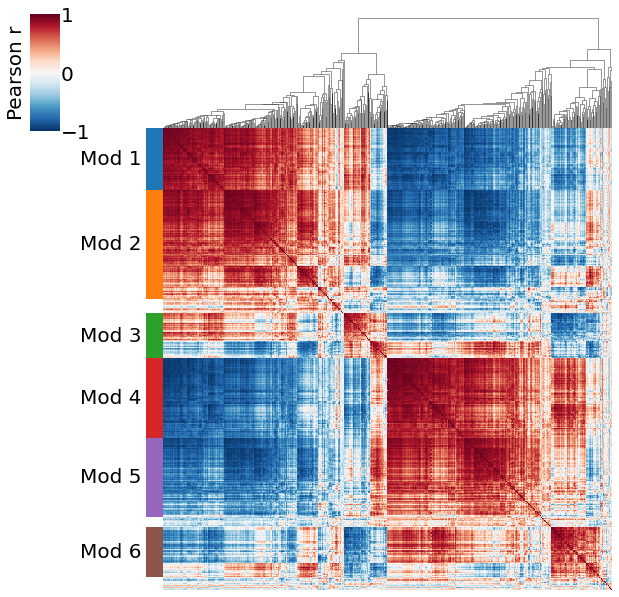

In [17]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit, logit, comb
from tqdm import tqdm
import seaborn as sns
import os
cm = 1/2.54
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.stats import zscore

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'


mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42
import sys

from scipy.cluster.hierarchy import leaves_list

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

gene_correlation = expression_avg.mask(expression_avg.isna()).T.corr().fillna(0)

gene_modules, gene_linkage = compute_modules_function(gene_correlation,min_gene_threshold=30, 
                                     fdr_threshold=None, z_threshold=0.3, core_only=False)
        
gene_modules = local_correlation_plot(gene_correlation, gene_modules, gene_linkage,
                            z_cmap='RdBu_r', yticklabels=False, plot_name = '')

In [18]:
def plot_gene_module_genes(mod):
    
    genes = gene_modules.loc[gene_modules == mod].index
    
    
    
    mod1_genes = expression_avg.index.intersection(genes)

    mod1_genes = zscore(expression_avg.loc[mod1_genes], axis=1).mean(axis=0)


    plt.tight_layout()
    fig = plt.figure(figsize=(9*cm, 6.25*cm))
    ax = fig.add_subplot(111, projection='3d')

    ax.grid(False)
    sc = ax.scatter(psix_object.latent.PC_1, psix_object.latent.PC_2, psix_object.latent.PC_3,
               c=mod1_genes, s=10, linewidth=0, alpha=0.8, cmap='inferno', vmin=-1, vmax=1)
    ax.set_yticks([-10, -5, 0, 5, 10])
    cb = plt.colorbar(sc, shrink = 0.5, aspect=5)
    cb.set_label(label='expression zscore',size=12)
    cb.ax.tick_params(labelsize=8, length=2)

    cb.outline.set_visible(False)
#     ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
#     ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
#     ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
#     ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.set_xlabel('PC 1', fontsize=12,labelpad=-10)
    ax.set_ylabel('PC 2', fontsize=12,labelpad=-10)
    ax.set_zlabel('PC 3', fontsize=12,labelpad=-12, rotation=90)
    ax.set_title('Module '+str(mod), fontsize=12)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    
    plt.savefig('plots/gene_expression_module_' + str(mod)+'.png', bbox_inches='tight', res=20000, dpi =2000)
    plt.show()

<Figure size 432x288 with 0 Axes>

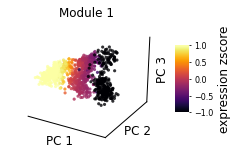

<Figure size 432x288 with 0 Axes>

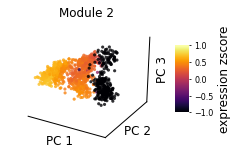

<Figure size 432x288 with 0 Axes>

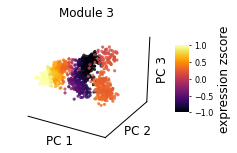

<Figure size 432x288 with 0 Axes>

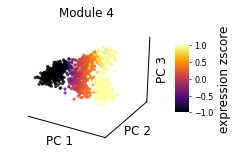

<Figure size 432x288 with 0 Axes>

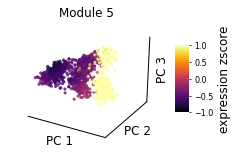

<Figure size 432x288 with 0 Axes>

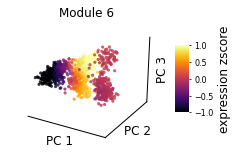

In [19]:
for i in range(1, 7):
    plot_gene_module_genes(i)

In [23]:
modules_df = pd.DataFrame(np.zeros((10, 6)),
                         index = ['exon_mod' + str(i+1) for i in range(10)],
                         columns = ['gene_mod' + str(i+1) for i in range(6)])

In [24]:
for i in range(1, 11):
    mod_genes = pd.Index(set([x.split('_')[0] for x in psix_object.modules.loc[psix_object.modules == i].index]))
    mod_genes = norm_tpm.index.intersection(mod_genes)
    
    for j in range(1, 7):
        
        M = len(gene_modules)
        n = (pd.DataFrame(gene_modules) == j).sum().iloc[0]
        N = len(mod_genes)
        k = (pd.DataFrame(gene_modules).loc[mod_genes] == j).sum().iloc[0]
        
        enrich = np.log2((k/N)/(n/M))
                
        modules_df.loc['exon_mod' + str(i), 'gene_mod' + str(j)] += enrich
    
    

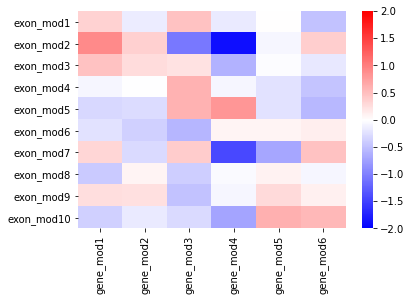

In [26]:
sns.heatmap(modules_df, cmap='bwr', vmin=-2, vmax=2)

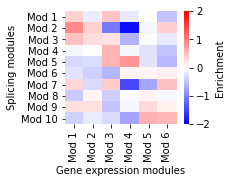

In [44]:
fig = plt.figure(figsize=(6/2.4, 5/2.4))
ax = fig.add_subplot(111)
sns.heatmap(modules_df, cmap='bwr', vmin=-2, vmax=2, ax=ax, cbar_kws={'label':'Enrichment'})
ax.set_xticklabels(['Mod 1', 'Mod 2', 'Mod 3', 'Mod 4', 'Mod 5', 'Mod 6'])
ax.set_yticklabels(['Mod 1', 'Mod 2', 'Mod 3', 'Mod 4', 'Mod 5', 
                    'Mod 6', 'Mod 7', 'Mod 8', 'Mod 9', 'Mod 10'])
ax.set_xlabel('Gene expression modules')
ax.set_ylabel('Splicing modules')
plt.savefig('plots/exon_vs_gene_modules_enrichnment.png', bbox_inches='tight', res=20000, dpi =2000)


In [55]:
ATres = pd.read_csv('data/ATres_counts.tab.gz', sep='\t', index_col=0)

from statsmodels.stats.multitest import multipletests
ATres['FDR'] = multipletests(ATres.pvalue)[1]

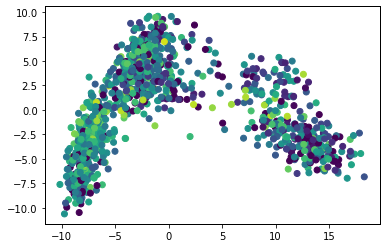

In [34]:
plt.scatter(psix_object.latent.PC_1, psix_object.latent.PC_2, c=norm_tpm.loc['Klf6'])

In [59]:
sig_genes = norm_tpm.index.intersection(ATres.loc[ATres['FDR'] <= 0.05].index)

expression_avg = get_all_exons_neighbors(
    np.array(norm_tpm.loc[sig_genes, 
                          psix_object.latent.index].T), 
    psix_object.metric
)

expression_avg = pd.DataFrame(expression_avg, index = sig_genes, columns = psix_object.latent.index)

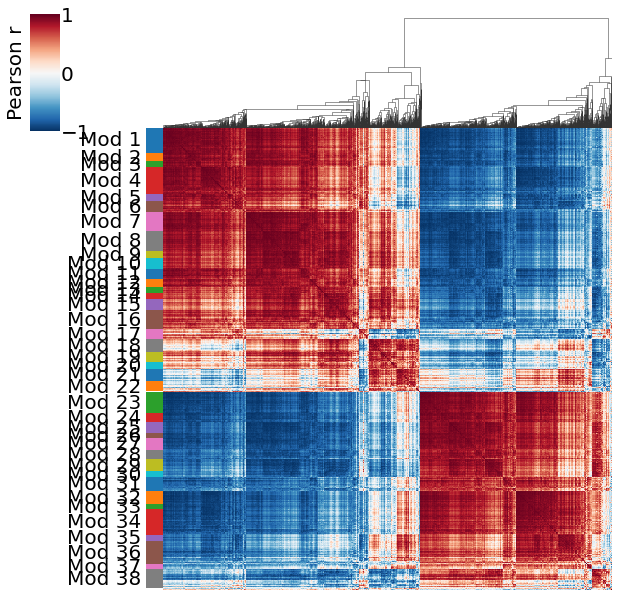

In [60]:
gene_correlation = expression_avg.mask(expression_avg.isna()).T.corr().fillna(0)

gene_modules, gene_linkage = compute_modules_function(gene_correlation,min_gene_threshold=30, 
                                     fdr_threshold=None, z_threshold=0.3, core_only=False)
        
gene_modules = local_correlation_plot(gene_correlation, gene_modules, gene_linkage,
                            z_cmap='RdBu_r', yticklabels=False, plot_name = '')

In [58]:
norm_tpm.index.intersection(sig_genes)

Index(['Gnai3', 'Narf', 'Cav2', 'Cox5a', 'Ccnd2', 'Nalcn', 'Th', 'Scpep1',
       'Tpd52l1', 'Cdh4',
       ...
       'Prmt1', 'Gm39244', 'Chmp1b', 'Gm19196', 'Gm45619', 'Gm45844', 'Igip',
       'Pde2a', 'Nudc-ps1', 'Gm45716'],
      dtype='object', length=2980)

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
from matplotlib import pyplot as plt
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/analysis_psix/utils/')
from utils_functions import *
from statsmodels.stats.multitest import multipletests


from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score


plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

In [6]:
weyn_pvals = pd.read_csv('../sc_bulk_comparison/bulk_data/weyn_pvals.tab.gz', sep='\t', index_col=0)
weyn_fdr = pd.read_csv('../sc_bulk_comparison/bulk_data/weyn_fdr.tab.gz', sep='\t', index_col=0)
weyn_psi = pd.read_csv('../sc_bulk_comparison/bulk_data/weyn_psi.tab.gz', sep='\t', index_col=0)
weyn_ds = get_averages_bulk(weyn_psi)

In [7]:
tiklova_PSI = pd.read_csv('psix_output/psix_object/psi.tab.gz', sep='\t', index_col=0)
tiklova_meta = pd.read_csv('data/SraRunTable.txt.gz', sep=',', index_col=0)
tiklova_psix = pd.read_csv('psix_output/psix_object/psix_results.tab.gz', sep='\t', index_col=0)

e13 = tiklova_meta.index[tiklova_meta.Age == 'embryonic day 13.5'] & tiklova_PSI.columns
e15 = tiklova_meta.index[tiklova_meta.Age == 'embryonic day 15.5'] & tiklova_PSI.columns
e18 = tiklova_meta.index[tiklova_meta.Age == 'embryonic day 18.5'] & tiklova_PSI.columns
p1 = tiklova_meta.index[tiklova_meta.Age == 'postnatal day 1'] & tiklova_PSI.columns
p7 = tiklova_meta.index[tiklova_meta.Age == 'postnatal day 7'] & tiklova_PSI.columns
p90 = tiklova_meta.index[tiklova_meta.Age == 'postnatal day 90'] & tiklova_PSI.columns

tiklova_labels = [e13, e15, e18, p1, p7, p90]
from scipy.stats import kruskal

def run_kw(exon_psi, labels):
    kw_input = []
    for l in labels:
        kw_input.append(list(exon_psi.loc[l]))
        
    if len(labels) == 2:
        return kruskal(kw_input[0], kw_input[1], nan_policy='omit')
    if len(labels) == 3:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], nan_policy='omit')
    if len(labels) == 4:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], nan_policy='omit')
    if len(labels) == 5:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], nan_policy='omit')
    if len(labels) == 6:
        return kruskal(kw_input[0], kw_input[1], kw_input[2], kw_input[3], kw_input[4], kw_input[5], nan_policy='omit')
    
def run_kw_dset(psi_table, labels, exon_list):
    kw_output = pd.DataFrame()
    kw_score = []
    pvals = []
    for exon in exon_list:
        score, p = run_kw(psi_table.loc[exon], labels)
        kw_score.append(score)
        pvals.append(p)
    kw_output['KW_score'] = kw_score
    kw_output['pvals'] = pvals
    kw_output['qvals'] = multipletests(pvals, method='fdr_bh')[1]
    kw_output.index = exon_list
    return kw_output

tiklova_kw = run_kw_dset(tiklova_PSI, tiklova_labels, tiklova_psix.index)

tiklova_gearyc = pd.read_csv('gearyc/gearyc.tab.gz', sep='\t', index_col=0)
tiklova_gearyc['qvals'] = multipletests(tiklova_gearyc.pvals, method='fdr_bh')[1]

one_v_one = 'brie2/'
tiklova_0v1 = pd.read_csv(one_v_one + 'brie_output_E13_v_E15/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
tiklova_0v2 = pd.read_csv(one_v_one + 'brie_output_E13_v_E18/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
tiklova_0v3 = pd.read_csv(one_v_one + 'brie_output_E13_v_P1/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
tiklova_0v4 = pd.read_csv(one_v_one + 'brie_output_E13_v_P7/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)
tiklova_0v5 = pd.read_csv(one_v_one + 'brie_output_E13_v_P90/brie_quant_cell.brie_ident.tsv', sep='\t', index_col=0)

tiklova_one_v_one = pd.DataFrame()
tiklova_one_v_one['0v1'] = tiklova_0v1.neuro_ELBO_gain
tiklova_one_v_one['0v2'] = tiklova_0v2.neuro_ELBO_gain
tiklova_one_v_one['0v3'] = tiklova_0v3.neuro_ELBO_gain
tiklova_one_v_one['0v4'] = tiklova_0v4.neuro_ELBO_gain
tiklova_one_v_one['0v5'] = tiklova_0v5.neuro_ELBO_gain
tiklova_ovo = tiklova_one_v_one.max(axis=1)


tiklova_one_v_one = pd.DataFrame()
tiklova_one_v_one['0v1'] = tiklova_0v1.neuro_FDR
tiklova_one_v_one['0v2'] = tiklova_0v2.neuro_FDR
tiklova_one_v_one['0v3'] = tiklova_0v3.neuro_FDR
tiklova_one_v_one['0v4'] = tiklova_0v4.neuro_FDR
tiklova_one_v_one['0v5'] = tiklova_0v5.neuro_FDR
tiklova_brie_qvals = tiklova_one_v_one.min(axis=1)

In [8]:
weyn_psi.loc[weyn_psi.index.intersection(psix_object.psix_results.index)]

,E14_rep1,E14_rep2,E16_rep1,E16_rep2,P0_rep1,P0_rep2,P4_rep1,P4_rep2,P7_rep1,P7_rep2,P15_rep1,P15_rep2,P30_rep1,P30_rep2,P110_rep1,P110_rep2,M21_rep1,M21_rep2
Ppfia2_5,0.917,0.932,0.930,0.929,0.749,0.841,0.863,0.861,0.840,0.838,0.812,0.821,0.886,0.855,0.892,0.856,0.827,0.837
Lin7a_1,0.930,0.883,0.893,0.925,0.779,0.846,0.886,0.800,0.737,0.713,0.699,0.733,0.753,0.726,0.738,0.700,0.838,0.737
Lin7a_2,0.102,0.056,0.052,0.000,0.063,0.077,0.014,0.014,0.066,0.025,0.091,0.072,0.155,0.126,0.220,0.158,0.122,0.256
Syt1_3,0.052,0.058,0.057,0.047,0.039,0.014,0.044,0.081,0.062,0.065,0.062,0.067,0.041,0.050,0.048,0.051,0.056,0.044
Thap2_1,0.660,0.788,0.772,0.798,0.839,0.871,0.945,0.782,0.879,0.811,0.724,0.753,0.690,0.663,0.712,0.849,0.849,0.637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gripap1_5,0.853,0.864,0.843,0.834,0.755,0.826,0.712,0.715,0.832,0.742,0.941,0.856,0.951,0.959,0.945,0.940,0.966,0.973
Gripap1_7,0.577,0.569,0.536,0.619,0.626,0.620,0.687,0.698,0.690,0.745,0.799,0.824,0.867,0.871,0.803,0.814,0.829,0.873
Rbm3_nmdSE_1,0.067,0.086,0.054,0.066,0.007,0.010,0.013,0.011,0.015,0.009,0.057,0.032,0.050,0.060,0.078,0.057,0.054,0.070
Arhgef9_2,0.492,0.359,0.262,0.352,0.314,0.460,0.382,0.394,0.288,0.332,0.173,0.220,0.196,0.193,0.162,0.204,0.176,0.141


In [9]:
ATres = pd.read_csv('data/ATres_counts.tab.gz', sep='\t', index_col=0)

from statsmodels.stats.multitest import multipletests
ATres['FDR'] = multipletests(ATres.pvalue)[1]

In [10]:
idx = [x.split('_')[0] for x in tiklova_psix]

In [11]:
weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

In [12]:
exon_idx = []
exon_meanLogFC = []
exon_gene_FDR = []
for exon in tqdm(weyn_fdr.index, leave=True, position=0):
    gene = exon.split('_')[0]
    if gene in ATres.index:
        exon_idx.append(exon)
        exon_gene_FDR.append(ATres.loc[gene, 'FDR'])
        exon_meanLogFC.append(ATres.loc[gene, 'meanLogFC'])

100%|██████████| 7066/7066 [00:00<00:00, 33689.65it/s]


In [13]:
ATres.meanLogFC

Gnai3            0.534997
Narf             0.407207
Cav2             0.833865
Klf6             0.277193
Scmh1            0.213815
                   ...   
Gm10252          0.608054
A030001D20Rik    0.430001
Gm45380          0.192035
Gm42303          1.345790
Gm45881          0.358250
Name: meanLogFC, Length: 11486, dtype: float64

In [14]:
isDE = pd.DataFrame(index=exon_idx)
isDE['FDR'] = exon_gene_FDR
isDE['exon_meanLogFC'] = exon_meanLogFC
isDE['DE'] = ((isDE.FDR <= 0.05) & (isDE.exon_meanLogFC >= 0.25))

In [15]:
np.exp(1)

2.718281828459045

In [16]:
isDE.exon_meanLogFC.max()

5.68747925818745

In [17]:
sig_exons = psix_object.psix_results.loc[psix_object.psix_results.qvals <= 0.05].index
nonsig_exons = psix_object.psix_results.loc[psix_object.psix_results.qvals > 0.05].index

In [18]:
isDE.loc[sig_exons.intersection(isDE.index)].DE.sum()

248

In [19]:
isDE.loc[nonsig_exons.intersection(isDE.index)].DE.sum()

247

In [20]:
psix_object.psix_results.index.intersection(isDE.index)

Index(['Mapt_1', 'Ndrg4_1', 'Dbn1_1', 'Mapt_3', 'Gabrg2_1', 'Cadm1_10',
       'Ncam1_6', 'Dst_5', 'Cadm1_3', 'Morf4l2_7',
       ...
       'Atrx_4', 'Chac2_1', 'Mtmr2_3', 'Ankrd42_1', 'Alg3_5', 'Pak3_6',
       'Med7_1', 'Zfp322a_1', 'Slc37a3_7', 'Plekha5_12'],
      dtype='object', length=1844)

In [21]:
sig_exons.intersection(isDE.index)

Index(['Mapt_1', 'Ndrg4_1', 'Dbn1_1', 'Mapt_3', 'Gabrg2_1', 'Cadm1_10',
       'Ncam1_6', 'Dst_5', 'Cadm1_3', 'Morf4l2_7',
       ...
       'Cbarp_nmdSE_1', 'Cpsf6_5', 'Lsm5_3', 'Tnks2_1', 'Cdadc1_3', 'Dlg4_3',
       'Hnrnpd_nmdSE_1', 'Oaz2_1', 'Dmtf1_7', 'Arfgap1_5'],
      dtype='object', length=738)

In [22]:
(248*1844)/(738*495)

1.251846377049629

In [23]:
isDE#.loc[sig_exons.intersection(isDE.index)].DE.mean()

,FDR,exon_meanLogFC,DE
Mettl25_nmdSE_2,1.0,0.235036,False
Ppfia2_3,1.0,0.227991,False
Ppfia2_5,1.0,0.227991,False
Grm1_1,0.0,1.284238,True
Lin7a_1,1.0,0.291261,False
...,...,...,...
Las1l_2,1.0,0.056510,False
Ophn1_1,1.0,0.272675,False
Eif2s3y_3,1.0,0.256174,False
Eif2s3y_1,1.0,0.256174,False


In [24]:
isDE.loc[psix_object.psix_results.index.intersection(isDE.index)].DE.mean()

0.26843817787418656

In [25]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

def get_samples_auc(psix, kw, gearyc, brie, pos, neg):

    exons = psix.index & gearyc.index & kw.index & brie.index
    exons_pos = pos & exons
    exons_neg = neg & exons


    kw_auc = []
    psix_auc = []
    gearyc_auc = []
    brie_auc = []

    for sample in tqdm(range(200)):
        pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
        neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)

        y = [1]*len(pos_choice) + [0]*len(neg_choice)
        c_y = list(gearyc.loc[pos_choice].C_score) + list(gearyc.loc[neg_choice].C_score)
        pre, rec, thres = precision_recall_curve(y, c_y)
        gearyc_auc.append(auc(rec, pre))

        y = [1]*len(pos_choice) + [0]*len(neg_choice)
        psix_y = list(psix.loc[pos_choice].psix_score) + list(psix.loc[neg_choice].psix_score)
        pre, rec, thres = precision_recall_curve(y, psix_y)
        psix_auc.append(auc(rec, pre))

        kw_y = list(kw.loc[pos_choice].KW_score) + list(kw.loc[neg_choice].KW_score)
        pre, rec, thres = precision_recall_curve(y, kw_y)
        kw_auc.append(auc(rec, pre))

        r_y = list(brie.loc[pos_choice]) + list(brie.loc[neg_choice])
        pre, rec, thres = precision_recall_curve([1]*len([x for x in pos_choice if x in brie.index]) + [0]*len([x for x in neg_choice if x in brie.index]), r_y)
        brie_auc.append(auc(rec, pre))
        #####


    return psix_auc, gearyc_auc, kw_auc, brie_auc



In [26]:
psix_all, gearyc_all, kw_all, brie_all = get_samples_auc(
    tiklova_psix, tiklova_kw, tiklova_gearyc, tiklova_ovo, weyn_pos, 
    weyn_neg)

100%|██████████| 200/200 [00:03<00:00, 59.87it/s]


In [27]:
psix_nonDE, gearyc_nonDE, kw_nonDE, brie_nonDE = get_samples_auc(
    tiklova_psix, tiklova_kw, tiklova_gearyc, tiklova_ovo, weyn_pos.intersection(isDE.loc[~isDE.DE].index), 
    weyn_neg.intersection(isDE.loc[~isDE.DE].index))

100%|██████████| 200/200 [00:03<00:00, 65.42it/s]


In [28]:
psix_DE, gearyc_DE, kw_DE, brie_DE = get_samples_auc(
    tiklova_psix, tiklova_kw, tiklova_gearyc, tiklova_ovo, weyn_pos.intersection(isDE.loc[isDE.DE].index), 
    weyn_neg.intersection(isDE.loc[isDE.DE].index))

100%|██████████| 200/200 [00:02<00:00, 79.82it/s]


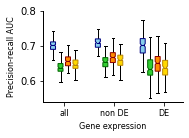

In [29]:
fig = plt.figure(figsize=(6/2.4, 4/2.4))
# gs = GridSpec(1,7)
# gs.update(wspace=0.05, hspace=0.10)
ax = fig.add_subplot(111)
# ax_2 = fig.add_subplot(gs[0,4:7])# option 1, specify props dictionaries

ax.boxplot([psix_all, psix_nonDE, psix_DE], positions=[1,5.5, 10], notch=True, patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='navy'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='navy'), showfliers=False
            )

ax.boxplot([kw_all, kw_nonDE, kw_DE], positions=[2.5,7, 11.5], notch=True, patch_artist=True,
            boxprops=dict(facecolor='darkorange', color='darkred'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='darkred'), showfliers=False
            )

ax.boxplot([gearyc_all, gearyc_nonDE, gearyc_DE], positions=[1.75,6.25, 10.75], notch=True, patch_artist=True,
            boxprops=dict(facecolor='limegreen', color='darkgreen'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='darkgreen'), showfliers=False
            )

ax.boxplot([brie_all, brie_nonDE, brie_DE], positions=[3.25,7.75, 12.25], notch=True, patch_artist=True,
            boxprops=dict(facecolor='gold', color='darkgoldenrod'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='darkgoldenrod'), showfliers=False
            )

ax.set_xticks([2.125, 7.125, 12.125])
ax.set_xticklabels(['all', 'non DE', 'DE'], size=8)
ax.set_xlabel('Gene expression', size=8)
# ax.set_title('Midbrain neurons', size=8)

ax.set_yticks([0.6, 0.7, 0.8])
# ax.set_yticklabels(['0.85', '0.90', '0.95'], size=8)
ax.set_ylabel('Precision-recall AUC', size=8)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlim([0, 14])

plt.savefig('plots/midbrain_pre-rec_auc_DEvnonDE.pdf', bbox_inches='tight', res=20000, dpi =2000)
plt.show()

In [ ]:
psix_all, gearyc_all, kw_all, brie_all = get_samples_auc(
    tiklova_psix, tiklova_kw, tiklova_gearyc, tiklova_ovo, weyn_pos, 
    weyn_neg)

In [73]:
idx = tiklova_psix.index.intersection(tiklova_ovo.index)
psix_pred = list(tiklova_psix.loc[weyn_pos.intersection(idx)].qvals <= 0.05) + list(tiklova_psix.loc[weyn_neg.intersection(idx)].qvals <= 0.05)
kw_pred = list(tiklova_kw.loc[weyn_pos.intersection(idx)].qvals <= 0.05) + list(tiklova_kw.loc[weyn_neg.intersection(idx)].qvals <= 0.05)
brie_qvals_pred = list(tiklova_brie_qvals.loc[weyn_pos.intersection(idx)] <= 0.05) + list(tiklova_brie_qvals.loc[weyn_neg.intersection(idx)] <= 0.05)

In [74]:
labels = [1]*len(weyn_pos.intersection(idx)) + [0]*len(weyn_neg.intersection(idx))

In [88]:
pre, rec, thres = precision_recall_curve(labels, list(tiklova_psix.loc[idx.intersection(weyn_pos)].psix_score)+ list(tiklova_psix.loc[idx.intersection(weyn_neg)].psix_score))
pre_2, rec_2, thres = precision_recall_curve(labels, list(tiklova_kw.loc[idx.intersection(weyn_pos)].KW_score)+ list(tiklova_kw.loc[idx.intersection(weyn_neg)].KW_score))
pre_1, rec_1, thres = precision_recall_curve(labels, list(tiklova_ovo.loc[idx.intersection(weyn_pos)])+ list(tiklova_ovo.loc[idx.intersection(weyn_neg)]))

(-0.05, 1.05)

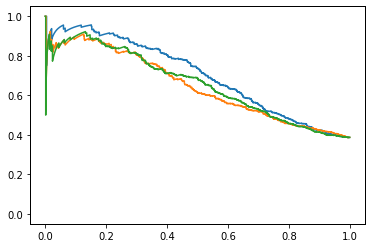

In [89]:
plt.plot(rec, pre)
plt.plot(rec_1, pre_1)
plt.plot(rec_2, pre_2)
plt.ylim(-0.05, 1.05)

In [112]:
def get_stats(x, pos, neg):
    
    pos = x.index.intersection(pos)
    neg = x.index.intersection(neg)
          
    labels = [1]*len(pos) + [0]*len(neg)
    pred = list(x.loc[pos]) + list(x.loc[neg])
          
    return precision_score(labels, pred), recall_score(labels, pred), f1_score(labels, pred)
          
    
def get_stats_DE(x, pos, neg, isDE):
    
    pos_DE = pos.intersection(isDE.loc[isDE.DE].index)
    neg_DE = neg.intersection(isDE.loc[isDE.DE].index)
    
    pos_nonDE = pos.intersection(isDE.loc[~isDE.DE].index)
    neg_nonDE = neg.intersection(isDE.loc[~isDE.DE].index)
    
    print('all')
    
    print(get_stats(x, pos, neg))
    
    print('DE')
    
    print(get_stats(x, pos_DE, neg_DE))
    
    print('nonDE')
    
    print(get_stats(x, pos_nonDE, neg_nonDE))

In [113]:
get_stats_DE(tiklova_psix.qvals <= 0.05, weyn_pos, weyn_neg, isDE)

all
(0.614247311827957, 0.625170998632011, 0.6196610169491524)
DE
(0.625, 0.7276995305164319, 0.6724511930585683)
nonDE
(0.6081632653061224, 0.5866141732283464, 0.597194388777555)


In [114]:
get_stats_DE(tiklova_kw.qvals <= 0.05, weyn_pos, weyn_neg, isDE)

all
(0.5023212627669452, 0.7400820793433652, 0.5984513274336283)
DE
(0.5249266862170088, 0.8403755868544601, 0.6462093862815884)
nonDE
(0.4972144846796657, 0.702755905511811, 0.5823817292006526)


In [115]:
get_stats_DE(tiklova_brie_qvals <= 0.05, weyn_pos, weyn_neg, isDE)

all
(0.4529320987654321, 0.8152777777777778, 0.5823412698412698)
DE
(0.48097826086956524, 0.8592233009708737, 0.6167247386759581)
nonDE
(0.44629014396456257, 0.7996031746031746, 0.5728500355366027)


In [105]:

get_stats(tiklova_brie_qvals <= 0.05, weyn_pos, weyn_neg)

(0.4529320987654321, 0.8152777777777778, 0.5823412698412698)

In [62]:
from scipy.stats import f_oneway, ranksums

In [63]:
f_oneway(psix_nonDE, psix_DE)

F_onewayResult(statistic=4.489194004701666, pvalue=0.034728676450897014)

In [25]:
ranksums(psix_nonDE, psix_DE)

RanksumsResult(statistic=1.5543059809105362, pvalue=0.1201114475618383)

In [26]:
tiklova_ovo

GeneID
Aamdc_9           1.9870
Aamdc_10          0.8613
Aasdhppt_2        8.1090
Abat_3           17.8800
Abca3_4           1.3110
                  ...   
Zscan18_1         2.2190
Zyx_1             2.1640
l7Rn6_1          18.5500
l7Rn6_3           8.4590
l7Rn6_nmdSE_1     2.8060
Length: 2047, dtype: float64

In [28]:
psix_prueba, gearyc_prueba, kw_prueba, brie_prueba = get_samples_auc(
    tiklova_psix, tiklova_kw, tiklova_gearyc, tiklova_ovo, weyn_pos.intersection(isDE.loc[~isDE.DE].index), 
    weyn_neg.intersection(isDE.loc[~isDE.DE].index))

100%|██████████| 200/200 [00:02<00:00, 79.80it/s]


In [29]:
pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

In [30]:
# weyn_ds = weyn_ds.loc[tiklova_psix.index & weyn_ds.index]

In [31]:
deltaPSI = weyn_ds.max(axis=1)
sigPSI = weyn_fdr.min(axis=1)

In [32]:
sigPSI

Kitl_3             6.429353e-05
Mettl25_nmdSE_2    7.745448e-09
Ppfia2_3           6.799492e-01
Ppfia2_5           1.516816e-04
Grm1_1             2.161687e-01
                       ...     
Las1l_2            2.038132e-07
Ophn1_1            1.816328e-01
Eif2s3y_3          0.000000e+00
Eif2s3y_1          7.855488e-01
Uty_2              4.863842e-03
Length: 7066, dtype: float64

In [33]:

bin_0 = deltaPSI.loc[(deltaPSI <= 0.01) | (sigPSI >0.05)].index
bin_0_20 = deltaPSI.loc[(deltaPSI > 0.01) & (deltaPSI <= 0.2) & (sigPSI <=0.05)].index
bin_20_40 = deltaPSI.loc[(deltaPSI > 0.2) & (deltaPSI <= 0.4) & (sigPSI <=0.05)].index
bin_40_60 = deltaPSI.loc[(deltaPSI > 0.4) & (deltaPSI <= 0.6) & (sigPSI <=0.05)].index
bin_60_80 = deltaPSI.loc[(deltaPSI > 0.6) & (deltaPSI <= 0.8) & (sigPSI <=0.05)].index
bin_80 = deltaPSI.loc[(deltaPSI > 0.8) & (sigPSI <=0.05)].index

def get_recall(predict, exon_bin):
    
    exon_bin = [x for x in exon_bin if x in predict.index]
    
    return recall_score(([True]*len(exon_bin)), predict.loc[[str(x) for x in exon_bin]])


def get_precision(predict, deltaPSI, cutoff):
    delta_pos = [str(x) for x in deltaPSI.loc[deltaPSI >= cutoff].index]
    delta_neg = [str(x) for x in deltaPSI.loc[deltaPSI < 0.01].index]
    
    delta_y = [True]*len(delta_pos) + [False]*len(delta_neg)
    
    print(len(delta_y))
    
    return precision_score(delta_y, predict.loc[delta_pos + delta_neg])

def plot_recall(x, y, color, label):
    plt.plot(x, y, c=color, linewidth=3)
    plt.scatter(x, y, s=80, facecolors='white', edgecolors=color, linewidth=3, label=label)

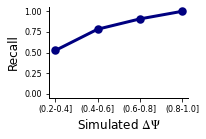

In [37]:
fig = plt.figure(figsize=(6/2.4, 4/2.4))
ax = fig.add_subplot(111)

plt.plot([ 0.4, 0.6, 0.8, 1.0],
     [get_recall((tiklova_psix.qvals <= 0.05), bin_20_40),
      get_recall((tiklova_psix.qvals <= 0.05), bin_40_60),
      get_recall((tiklova_psix.qvals <= 0.05), bin_60_80),
      get_recall((tiklova_psix.qvals <= 0.05), bin_80)],
        c='navy', linewidth=3)

plt.scatter([ 0.4, 0.6, 0.8, 1.0],
     [get_recall((tiklova_psix.qvals <= 0.05), bin_20_40),
      get_recall((tiklova_psix.qvals <= 0.05), bin_40_60),
      get_recall((tiklova_psix.qvals <= 0.05), bin_60_80),
      get_recall((tiklova_psix.qvals <= 0.05), bin_80)],
            s=30, c='navy', linewidth=3)

plt.xlabel(r'Simulated $\Delta \Psi$', fontsize=12)
plt.ylabel('Recall', fontsize=12)
ax.set_xticks([ 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels(['(0.2-0.4]', '(0.4-0.6]', '(0.6-0.8]', '(0.8-1.0]'])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.ylim([-0.05, 1.05])

ax.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('plots/delta_psi_psix_recall.png', bbox_inches='tight', res=20000, dpi =2000)
plt.show()

In [93]:
tiklova_brie_qvals

GeneID
Aamdc_9          1.0000
Aamdc_10         1.0000
Aasdhppt_2       1.0000
Abat_3           0.7159
Abca3_4          0.5395
                  ...  
Zscan18_1        1.0000
Zyx_1            1.0000
l7Rn6_1          0.8183
l7Rn6_3          0.6061
l7Rn6_nmdSE_1    1.0000
Length: 2047, dtype: float64

In [53]:
tiklova_ovo

GeneID
Aamdc_9           1.9870
Aamdc_10          0.8613
Aasdhppt_2        8.1090
Abat_3           17.8800
Abca3_4           1.3110
                  ...   
Zscan18_1         2.2190
Zyx_1             2.1640
l7Rn6_1          18.5500
l7Rn6_3           8.4590
l7Rn6_nmdSE_1     2.8060
Length: 2047, dtype: float64

(array([209., 351., 334., 245., 177., 128., 115.,  79.,  53.,  50.,  36.,
         23.,  24.,  19.,  12.,  10.,   4.,   7.,   4.,   3.]),
 array([0.009   , 0.057525, 0.10605 , 0.154575, 0.2031  , 0.251625,
        0.30015 , 0.348675, 0.3972  , 0.445725, 0.49425 , 0.542775,
        0.5913  , 0.639825, 0.68835 , 0.736875, 0.7854  , 0.833925,
        0.88245 , 0.930975, 0.9795  ]),
 <a list of 20 Patch objects>)

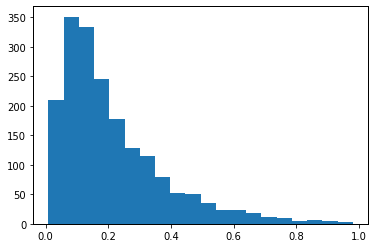

In [112]:
plt.hist(deltaPSI.loc[deltaPSI.index.intersection(psix_object.psix_results.index)], bins=20)

(array([216., 360., 348., 329., 296., 260., 232., 190., 166., 131., 115.,
         97.,  80.,  48.,  50.,  28.,  23.,  20.,   7.,  10.]),
 array([0.013   , 0.061325, 0.10965 , 0.157975, 0.2063  , 0.254625,
        0.30295 , 0.351275, 0.3996  , 0.447925, 0.49625 , 0.544575,
        0.5929  , 0.641225, 0.68955 , 0.737875, 0.7862  , 0.834525,
        0.88285 , 0.931175, 0.9795  ]),
 <a list of 20 Patch objects>)

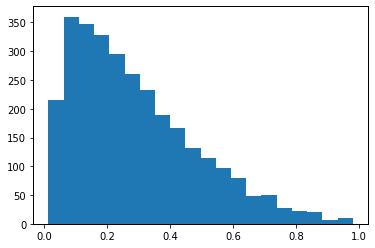

In [122]:
plt.hist(deltaPSI.loc[(weyn_fdr.min(axis=1) <= 0.001)], bins=20)

In [120]:
weyn_fdr.loc[(weyn_fdr.min(axis=1) <= 0.05)].min(axis=1)

Kitl_3             6.429353e-05
Mettl25_nmdSE_2    7.745448e-09
Ppfia2_5           1.516816e-04
Lin7a_1            1.882555e-02
Ppp1r12a_5         7.123248e-05
                       ...     
Arhgef9_9          6.088298e-07
Arhgef9_2          1.026516e-06
Las1l_2            2.038132e-07
Eif2s3y_3          0.000000e+00
Uty_2              4.863842e-03
Length: 4801, dtype: float64

In [120]:
def get_stats(x, pos, neg):
    
    pos = x.index.intersection(pos)
    neg = x.index.intersection(neg)
          
    labels = [1]*len(pos) + [0]*len(neg)
    pred = list(x.loc[pos]) + list(x.loc[neg])
    
    stats_dict = {}
    
    stats_dict.update({'precision':precision_score(labels, pred)})
    stats_dict.update({'recall':recall_score(labels, pred)})
    stats_dict.update({'f1_score':f1_score(labels, pred)})
          
    return stats_dict
          
    
def get_stats_DE(x, pos, neg, isDE):
    
    pos_DE = pos.intersection(isDE.loc[isDE].index)
    neg_DE = neg.intersection(isDE.loc[isDE].index)
    
    pos_nonDE = pos.intersection(isDE.loc[~isDE].index)
    neg_nonDE = neg.intersection(isDE.loc[~isDE].index)
    
    stats_dict = {}
    
    stats_dict.update({'all':get_stats(x, pos, neg)})
    stats_dict.update({'DE':get_stats(x, pos_DE, neg_DE)})
    stats_dict.update({'nonDE':get_stats(x, pos_nonDE, neg_nonDE)})
    
    return stats_dict



psix_stats =[]
kw_stats = []
gearyc_stats = []
brie_stats = []
for i in tqdm(range(200), position=0, leave=True):
    psix_stats.append(get_stats_DE(tiklova_psix.qvals <= 0.05, 
                              pd.Index(np.random.choice(weyn_pos.intersection(tiklova_psix.index), int(len(weyn_pos.intersection(tiklova_psix.index))*0.2), replace=False)), 
                              pd.Index(np.random.choice(weyn_neg.intersection(tiklova_psix.index), int(len(weyn_neg.intersection(tiklova_psix.index))*0.2), replace=False)), 
                              isDE.DE))
    
    kw_stats.append(get_stats_DE(tiklova_kw.qvals <= 0.05, 
                              pd.Index(np.random.choice(weyn_pos.intersection(tiklova_kw.index), int(len(weyn_pos.intersection(tiklova_kw.index))*0.2), replace=False)), 
                              pd.Index(np.random.choice(weyn_neg.intersection(tiklova_kw.index), int(len(weyn_neg.intersection(tiklova_kw.index))*0.2), replace=False)), 
                              isDE.DE))
    
    gearyc_stats.append(get_stats_DE(tiklova_gearyc.qvals <= 0.05, 
                              pd.Index(np.random.choice(weyn_pos.intersection(tiklova_gearyc.index), int(len(weyn_pos.intersection(tiklova_gearyc.index))*0.2), replace=False)), 
                              pd.Index(np.random.choice(weyn_neg.intersection(tiklova_gearyc.index), int(len(weyn_neg.intersection(tiklova_gearyc.index))*0.2), replace=False)), 
                              isDE.DE))
    
    
    
    
    brie_stats.append(get_stats_DE(tiklova_brie_qvals <= 0.05, 
                              pd.Index(np.random.choice(weyn_pos.intersection(tiklova_brie_qvals.index), int(len(weyn_pos.intersection(tiklova_brie_qvals.index))*0.2), replace=False)), 
                              pd.Index(np.random.choice(weyn_neg.intersection(tiklova_brie_qvals.index), int(len(weyn_neg.intersection(tiklova_brie_qvals.index))*0.2), replace=False)), 
                              isDE.DE))

100%|██████████| 200/200 [00:26<00:00,  7.68it/s]


In [121]:
all_psix_stats = get_stats_DE(tiklova_psix.qvals <= 0.05, weyn_pos, weyn_neg, isDE.DE)
all_kw_stats = get_stats_DE(tiklova_kw.qvals <= 0.05, weyn_pos, weyn_neg, isDE.DE)
all_gearyc_stats = get_stats_DE(tiklova_gearyc.qvals <= 0.05, weyn_pos, weyn_neg, isDE.DE)
all_brie_stats = get_stats_DE(tiklova_brie_qvals <= 0.05, weyn_pos, weyn_neg, isDE.DE)

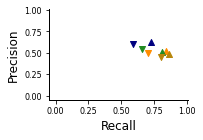

In [122]:
fig = plt.figure(figsize=(6/2.4, 4/2.4))
ax = fig.add_subplot(111)

ax.scatter([all_psix_stats['DE']['recall']], [all_psix_stats['DE']['precision']], c='navy', marker='^')
ax.scatter([all_psix_stats['nonDE']['recall']], [all_psix_stats['nonDE']['precision']], c='navy', marker='v')


ax.scatter([all_kw_stats['DE']['recall']], [all_kw_stats['DE']['precision']], c='darkorange', marker='^')
ax.scatter([all_kw_stats['nonDE']['recall']], [all_kw_stats['nonDE']['precision']], c='darkorange', marker='v')

ax.scatter([all_gearyc_stats['DE']['recall']], [all_gearyc_stats['DE']['precision']], c='forestgreen', marker='^')
ax.scatter([all_gearyc_stats['nonDE']['recall']], [all_gearyc_stats['nonDE']['precision']], c='forestgreen', marker='v')
ax.set_xlim([-0.05, 1.01])
ax.set_ylim([-0.05, 1.01])

ax.scatter([all_brie_stats['DE']['recall']], [all_brie_stats['DE']['precision']], c='darkgoldenrod', marker='^')
ax.scatter([all_brie_stats['nonDE']['recall']], [all_brie_stats['nonDE']['precision']], c='darkgoldenrod', marker='v')
ax.set_xlim([-0.05, 1.01])
ax.set_ylim([-0.05, 1.01])


plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=8)

# Binding maps

In [54]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
import subprocess as sp
from scipy.stats.mstats import zscore

from scipy.stats import pearsonr, spearmanr

In [55]:
binding = pd.read_csv('~/old_files/rbp_binding/tables/peaks_clip_tags.tab', sep='\t', index_col=0)

In [56]:
def plot_binding(binding, rbp, modules, pos_modules, neg_modules, pos_label='positives', neg_label='negatives', plot_name = '_plot'):
    
    pos_supra_module = pd.Index([])
    for pos in pos_modules:
        pos_supra_module = pos_supra_module | modules.loc[modules == pos].index
        
    neg_supra_module = pd.Index([])
    for neg in neg_modules:
        neg_supra_module = neg_supra_module | modules.loc[modules == neg].index

    binding_e1_module = np.zeros(550)
    binding_s1_module = np.zeros(550)
    binding_s2_module = np.zeros(550)
    binding_e2_module = np.zeros(550)
    for exon in tqdm(pos_supra_module, leave=True, position=0):

        binding_e1 = []
        binding_s1 = []
        binding_s2 = []
        binding_e2 = []
        for i in range(1, 551):
            binding_e1.append(binding.loc[exon + '_e1:'+str(i), rbp])
            binding_s1.append(binding.loc[exon + '_s1:'+str(i), rbp])
            binding_s2.append(binding.loc[exon + '_s2:'+str(i), rbp])
            binding_e2.append(binding.loc[exon + '_e2:'+str(i), rbp])

        total = np.array(binding_e1 + binding_s1 + binding_s2 + binding_e2)
        scale = (np.max(total) - np.min(total))*len(pos_supra_module)

        if scale > 0:
            binding_e1_module += (np.array(binding_e1) - np.min(total))/scale
            binding_s1_module += (np.array(binding_s1) - np.min(total))/scale
            binding_s2_module += (np.array(binding_s2) - np.min(total))/scale
            binding_e2_module += (np.array(binding_e2) - np.min(total))/scale

    plt.figure()
    plt.plot(range(1, 551), binding_e1_module, c='navy', label=pos_label)
    plt.plot([700 + i for i in range(1, 551)], binding_s1_module, c='navy')
    plt.plot([1400 + i for i in range(1, 551)], binding_s2_module, c='navy')
    plt.plot([2100 + i for i in range(1, 551)], binding_e2_module, c='navy')



    binding_e1_module = np.zeros(550)
    binding_s1_module = np.zeros(550)
    binding_s2_module = np.zeros(550)
    binding_e2_module = np.zeros(550)

    for exon in tqdm(neg_supra_module, leave=True, position=0):

        binding_e1 = []
        binding_s1 = []
        binding_s2 = []
        binding_e2 = []
        for i in range(1, 551):
            binding_e1.append(binding.loc[exon + '_e1:'+str(i), rbp])
            binding_s1.append(binding.loc[exon + '_s1:'+str(i), rbp])
            binding_s2.append(binding.loc[exon + '_s2:'+str(i), rbp])
            binding_e2.append(binding.loc[exon + '_e2:'+str(i), rbp])

        total = np.array(binding_e1 + binding_s1 + binding_s2 + binding_e2)
        scale = (np.max(total) - np.min(total))*len(neg_supra_module)

        if scale > 0:
            binding_e1_module += (np.array(binding_e1) - np.min(total))/scale
            binding_s1_module += (np.array(binding_s1) - np.min(total))/scale
            binding_s2_module += (np.array(binding_s2) - np.min(total))/scale
            binding_e2_module += (np.array(binding_e2) - np.min(total))/scale

    plt.plot(range(1, 551), -binding_e1_module, c='red', label=neg_label)
    plt.plot([700 + i for i in range(1, 551)], -binding_s1_module, c='red')
    plt.plot([1400 + i for i in range(1, 551)], -binding_s2_module, c='red')
    plt.plot([2100 + i for i in range(1, 551)], -binding_e2_module, c='red')

    plt.xlabel('Position')
    plt.ylabel('Scaled binding score')
    plt.title(rbp + ' binding ' + plot_name)

    plt.plot([0, 550], [0, 0], c='black')
    plt.plot([700, 1200], [0, 0], c='black')
    plt.plot([1410, 1950], [0, 0], c='black')
    plt.plot([2100, 2600], [0, 0], c='black')

    plt.fill_between([-50, 50], [-0.01, -0.01], [0.01, 0.01], color='navy')
    plt.fill_between([1200, 1450], [-0.01, -0.01], [0.01, 0.01], color='skyblue')
    plt.fill_between([1200, 1250], [-0.01, -0.01], [0.01, 0.01], color='navy')
    plt.fill_between([1400, 1450], [-0.01, -0.01], [0.01, 0.01], color='navy')
    plt.fill_between([2600, 2700], [-0.01, -0.01], [0.01, 0.01], color='navy')

    plt.legend(frameon=False)
    
#     plt.ylim((-0.075, 0.075))
    
#     plt.savefig('binding_plots_extended/'+rbp + '_' + plot_name + '.png')
    
    plt.show()

In [57]:
def plot_binding(binding, rbp, modules, pos_modules, neg_modules, pos_label='positives', neg_label='negatives', plot_name = '_plot'):
    
    pos_supra_module = pd.Index([])
    for pos in pos_modules:
        pos_supra_module = pos_supra_module | modules.loc[modules == pos].index
        
    neg_supra_module = pd.Index([])
    for neg in neg_modules:
        neg_supra_module = neg_supra_module | modules.loc[modules == neg].index

    binding_e1_module = np.zeros(230)
    binding_s1_module = np.zeros(230)
    binding_s2_module = np.zeros(230)
    binding_e2_module = np.zeros(230)
    for exon in tqdm(pos_supra_module, leave=True, position=0):

        binding_e1 = []
        binding_s1 = []
        binding_s2 = []
        binding_e2 = []
        for i in range(1, 231):
            binding_e1.append(binding.loc[exon + '_e1:'+str(i), rbp])
            binding_s1.append(binding.loc[exon + '_s1:'+str(i), rbp])
            binding_s2.append(binding.loc[exon + '_s2:'+str(i), rbp])
            binding_e2.append(binding.loc[exon + '_e2:'+str(i), rbp])

        total = np.array(binding_e1 + binding_s1 + binding_s2 + binding_e2)
        scale = (np.max(total) - np.min(total))*len(pos_supra_module)

        if scale > 0:
            binding_e1_module += (np.array(binding_e1) - np.min(total))/scale
            binding_s1_module += (np.array(binding_s1) - np.min(total))/scale
            binding_s2_module += (np.array(binding_s2) - np.min(total))/scale
            binding_e2_module += (np.array(binding_e2) - np.min(total))/scale

    plt.figure()
    plt.plot(range(1, 231), binding_e1_module, c='navy', label=pos_label)
    plt.plot([300 + i for i in range(1, 231)], binding_s1_module, c='navy')
    plt.plot([600 + i for i in range(1, 231)], binding_s2_module, c='navy')
    plt.plot([900 + i for i in range(1, 231)], binding_e2_module, c='navy')



    binding_e1_module = np.zeros(230)
    binding_s1_module = np.zeros(230)
    binding_s2_module = np.zeros(230)
    binding_e2_module = np.zeros(230)

    for exon in tqdm(neg_supra_module, leave=True, position=0):

        binding_e1 = []
        binding_s1 = []
        binding_s2 = []
        binding_e2 = []
        for i in range(1, 231):
            binding_e1.append(binding.loc[exon + '_e1:'+str(i), rbp])
            binding_s1.append(binding.loc[exon + '_s1:'+str(i), rbp])
            binding_s2.append(binding.loc[exon + '_s2:'+str(i), rbp])
            binding_e2.append(binding.loc[exon + '_e2:'+str(i), rbp])

        total = np.array(binding_e1 + binding_s1 + binding_s2 + binding_e2)
        scale = (np.max(total) - np.min(total))*len(neg_supra_module)

        if scale > 0:
            binding_e1_module += (np.array(binding_e1) - np.min(total))/scale
            binding_s1_module += (np.array(binding_s1) - np.min(total))/scale
            binding_s2_module += (np.array(binding_s2) - np.min(total))/scale
            binding_e2_module += (np.array(binding_e2) - np.min(total))/scale

    plt.plot(range(1, 231), -binding_e1_module, c='red', label=neg_label)
    plt.plot([300 + i for i in range(1, 231)], -binding_s1_module, c='red')
    plt.plot([600 + i for i in range(1, 231)], -binding_s2_module, c='red')
    plt.plot([900 + i for i in range(1, 231)], -binding_e2_module, c='red')

    plt.xlabel('Position')
    plt.ylabel('Scaled binding score')
    plt.title(rbp + ' binding')

    plt.plot([0, 230], [0, 0], c='black')
    plt.plot([330, 500], [0, 0], c='black')
    plt.plot([610, 830], [0, 0], c='black')
    plt.plot([900, 1100], [0, 0], c='black')

    plt.fill_between([-30, 30], [-0.01, -0.01], [0.01, 0.01], color='navy')
    plt.fill_between([500, 630], [-0.01, -0.01], [0.01, 0.01], color='skyblue')
    plt.fill_between([500, 530], [-0.01, -0.01], [0.01, 0.01], color='navy')
    plt.fill_between([600, 630], [-0.01, -0.01], [0.01, 0.01], color='navy')
    plt.fill_between([1100, 1160], [-0.01, -0.01], [0.01, 0.01], color='navy')

    plt.legend(frameon=False)
    
    plt.ylim((-0.075, 0.075))
    
#     plt.savefig('binding_plots/'+rbp + plot_name + '.png')
    
    plt.show()

100%|██████████| 99/99 [00:01<00:00, 67.72it/s]


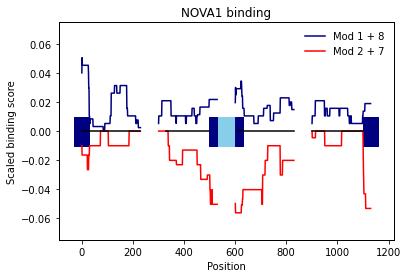

In [34]:
# for rbp in binding.columns:
plot_binding(binding, 'NOVA1', 
             psix_object.modules, [1, 8], [2, 7], pos_label='Mod 1 + 8', neg_label='Mod 2 + 7',
            plot_name = '_Mod-1:8-2:7')

In [58]:
binding = pd.read_csv('~/old_files/rbp_binding/tables/peaks_clip_tags_extended.tab', sep='\t', index_col=0)
binding = (binding > 0).astype(int)

In [59]:
binding

,SRRM4,FMR1,PTBP1,RBM3,SRSF1,SRSF6,NOVA2,MBNL1,TARDBP,PABPC1,...,AGO2,RBFOX1,FUS,CELF1,TAF15,SRSF4,CIRBP,RBFOX2,SRSF3,UPF1
AA467197_1_e1:1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AA467197_1_e1:2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AA467197_1_e1:3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AA467197_1_e1:4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AA467197_1_e1:5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zzz3_11_e2:547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zzz3_11_e2:548,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zzz3_11_e2:549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zzz3_11_e2:550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
def plot_binding(binding, rbp, pos_supra_module, neg_supra_module, pos_label='positives', neg_label='negatives', plot_name = '_plot'):
    
#     pos_supra_module = pd.Index([])
#     for pos in pos_modules:
#         pos_supra_module = pos_supra_module | modules.loc[modules == pos].index
        
#     neg_supra_module = pd.Index([])
#     for neg in neg_modules:
#         neg_supra_module = neg_supra_module | modules.loc[modules == neg].index

    binding_e1_module = np.zeros(550)
    binding_s1_module = np.zeros(550)
    binding_s2_module = np.zeros(550)
    binding_e2_module = np.zeros(550)
    
    
    
    for exon in tqdm(pos_supra_module, leave=True, position=0):

        binding_e1 = []
        binding_s1 = []
        binding_s2 = []
        binding_e2 = []
        for i in range(1, 551):
            binding_e1.append(binding.loc[exon + '_e1:'+str(i), rbp])
            binding_s1.append(binding.loc[exon + '_s1:'+str(i), rbp])
            binding_s2.append(binding.loc[exon + '_s2:'+str(i), rbp])
            binding_e2.append(binding.loc[exon + '_e2:'+str(i), rbp])

        total = np.array(binding_e1 + binding_s1 + binding_s2 + binding_e2)
        scale = len(pos_supra_module)

        if scale > 0:
            binding_e1_module += (np.array(binding_e1) - np.min(total))/scale
            binding_s1_module += (np.array(binding_s1) - np.min(total))/scale
            binding_s2_module += (np.array(binding_s2) - np.min(total))/scale
            binding_e2_module += (np.array(binding_e2) - np.min(total))/scale

    plt.figure()
    
    
    plt.plot(range(1, 551), binding_e1_module, c='navy', label=pos_label)
    plt.plot([700 + i for i in range(1, 551)], binding_s1_module, c='navy')
    plt.plot([1400 + i for i in range(1, 551)], binding_s2_module, c='navy')
    plt.plot([2100 + i for i in range(1, 551)], binding_e2_module, c='navy')
    
    plt.fill_between(range(1, 551), np.zeros(550), binding_e1_module, color='navy', alpha=0.3)
    plt.fill_between([700 + i for i in range(1, 551)], np.zeros(550), binding_s1_module, color='navy', alpha=0.3)
    plt.fill_between([1400 + i for i in range(1, 551)], np.zeros(550), binding_s2_module, color='navy', alpha=0.3)
    plt.fill_between([2100 + i for i in range(1, 551)], np.zeros(550), binding_e2_module, color='navy', alpha=0.3)



    binding_e1_module = np.zeros(550)
    binding_s1_module = np.zeros(550)
    binding_s2_module = np.zeros(550)
    binding_e2_module = np.zeros(550)

    for exon in tqdm(neg_supra_module, leave=True, position=0):

        binding_e1 = []
        binding_s1 = []
        binding_s2 = []
        binding_e2 = []
        for i in range(1, 551):
            binding_e1.append(binding.loc[exon + '_e1:'+str(i), rbp])
            binding_s1.append(binding.loc[exon + '_s1:'+str(i), rbp])
            binding_s2.append(binding.loc[exon + '_s2:'+str(i), rbp])
            binding_e2.append(binding.loc[exon + '_e2:'+str(i), rbp])

        total = np.array(binding_e1 + binding_s1 + binding_s2 + binding_e2)
        scale = len(neg_supra_module)

        if scale > 0:
            binding_e1_module += (np.array(binding_e1) - np.min(total))/scale
            binding_s1_module += (np.array(binding_s1) - np.min(total))/scale
            binding_s2_module += (np.array(binding_s2) - np.min(total))/scale
            binding_e2_module += (np.array(binding_e2) - np.min(total))/scale
            
    plt.plot(range(1, 551), -binding_e1_module, c='red', label=neg_label)
    plt.plot([700 + i for i in range(1, 551)], -binding_s1_module, c='red')
    plt.plot([1400 + i for i in range(1, 551)], -binding_s2_module, c='red')
    plt.plot([2100 + i for i in range(1, 551)], -binding_e2_module, c='red')
    
    plt.fill_between(range(1, 551), -binding_e1_module, np.zeros(550), color='red', alpha=0.3)
    plt.fill_between([700 + i for i in range(1, 551)], -binding_s1_module, np.zeros(550), color='red', alpha=0.3)
    plt.fill_between([1400 + i for i in range(1, 551)], -binding_s2_module, np.zeros(550), color='red', alpha=0.3)
    plt.fill_between([2100 + i for i in range(1, 551)], -binding_e2_module, np.zeros(550), color='red', alpha=0.3)

    plt.xlabel('Position')
    plt.ylabel('Scaled binding score')
    plt.title(rbp + ' binding ' + plot_name)

    plt.plot([0, 550], [0, 0], c='black')
    plt.plot([700, 1200], [0, 0], c='black')
    plt.plot([1410, 1950], [0, 0], c='black')
    plt.plot([2100, 2600], [0, 0], c='black')

    plt.fill_between([-50, 50], [-0.01, -0.01], [0.01, 0.01], color='navy')
    plt.fill_between([1200, 1450], [-0.01, -0.01], [0.01, 0.01], color='skyblue')
    plt.fill_between([1200, 1250], [-0.01, -0.01], [0.01, 0.01], color='navy')
    plt.fill_between([1400, 1450], [-0.01, -0.01], [0.01, 0.01], color='navy')
    plt.fill_between([2600, 2700], [-0.01, -0.01], [0.01, 0.01], color='navy')

    plt.legend(frameon=False)
    
#     plt.ylim((-0.075, 0.075))
    
#     plt.savefig('binding_plots_extended/'+rbp + '_' + plot_name + '.png')
    
    plt.show()

100%|██████████| 1289/1289 [00:42<00:00, 30.40it/s]


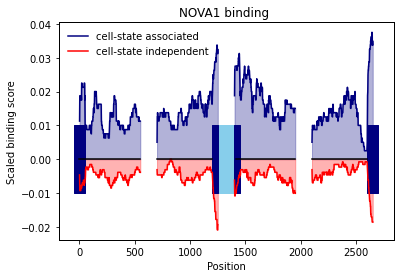

In [61]:
# for rbp in binding.columns:
plot_binding(binding, 'NOVA1', 
             psix_object.psix_results.loc[psix_object.psix_results.qvals <= 0.05].index, 
             psix_object.psix_results.loc[psix_object.psix_results.qvals >= 0.05].index, 
             pos_label='cell-state associated', neg_label='cell-state independent',
            plot_name = '')

100%|██████████| 1289/1289 [00:55<00:00, 23.27it/s]


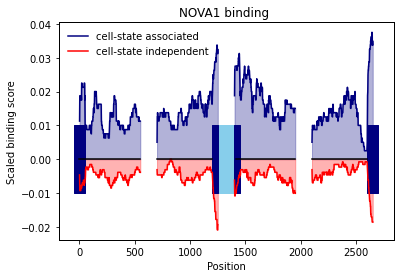

In [262]:
# for rbp in binding.columns:
plot_binding(binding, 'NOVA1', 
             psix_object.psix_results.loc[psix_object.psix_results.qvals <= 0.05].index, 
             psix_object.psix_results.loc[psix_object.psix_results.qvals >= 0.05].index, 
             pos_label='cell-state associated', neg_label='cell-state independent',
            plot_name = '')

100%|██████████| 1289/1289 [00:46<00:00, 27.78it/s]


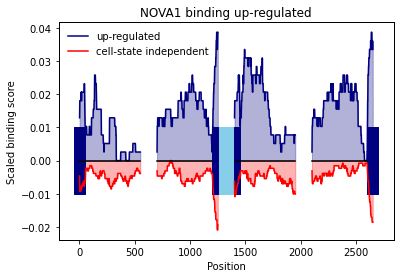

In [62]:
# for rbp in binding.columns:
plot_binding(binding, 'NOVA1', 
             psix_object.modules.loc[(psix_object.modules<=5) & (psix_object.modules>0)].index, 
             psix_object.psix_results.loc[psix_object.psix_results.qvals >= 0.05].index, 
             pos_label='up-regulated', neg_label='cell-state independent',
            plot_name = 'up-regulated')

100%|██████████| 1289/1289 [00:43<00:00, 29.92it/s]


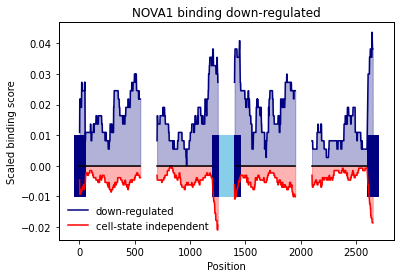

In [63]:
# for rbp in binding.columns:
plot_binding(binding, 'NOVA1', 
             psix_object.modules.loc[(psix_object.modules>5)].index, 
             psix_object.psix_results.loc[psix_object.psix_results.qvals >= 0.05].index, 
             pos_label='down-regulated', neg_label='cell-state independent',
            plot_name = 'down-regulated')

100%|██████████| 1289/1289 [00:56<00:00, 22.94it/s]


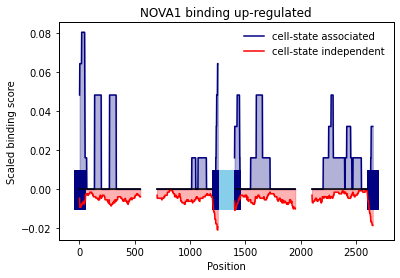

 46%|████▌     | 591/1289 [00:23<00:27, 25.41it/s]


KeyboardInterrupt: 

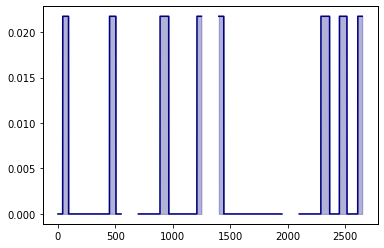

In [263]:
# for rbp in binding.columns:

for i in range(1, 11):
    plot_binding(binding, 'NOVA1', 
                 psix_object.modules.loc[psix_object.modules==i].index, 
                 psix_object.psix_results.loc[psix_object.psix_results.qvals >= 0.05].index, 
                 pos_label='cell-state associated', neg_label='cell-state independent',
                plot_name = 'up-regulated')

100%|██████████| 1289/1289 [00:46<00:00, 27.96it/s]


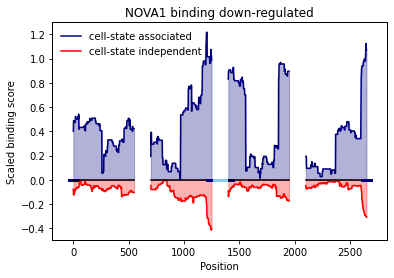

In [34]:
# for rbp in binding.columns:
plot_binding(binding, 'NOVA1', 
             psix_object.modules.loc[(psix_object.modules>=6)].index, 
             psix_object.psix_results.loc[psix_object.psix_results.qvals >= 0.05].index, 
             pos_label='cell-state associated', neg_label='cell-state independent',
            plot_name = 'down-regulated')

100%|██████████| 1289/1289 [00:40<00:00, 31.54it/s]


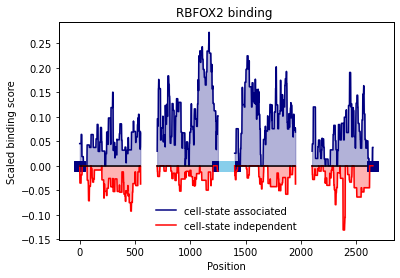

In [30]:
# for rbp in binding.columns:
plot_binding(binding, 'RBFOX2', 
             psix_object.psix_results.loc[psix_object.psix_results.qvals <= 0.05].index, 
             psix_object.psix_results.loc[psix_object.psix_results.qvals >= 0.05].index, 
             pos_label='cell-state associated', neg_label='cell-state independent',
            plot_name = '')

100%|██████████| 1289/1289 [00:41<00:00, 30.83it/s]


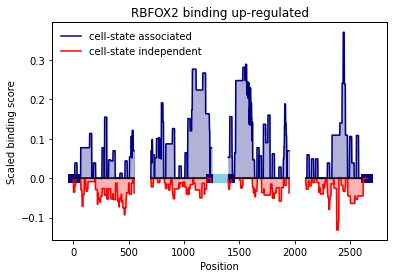

In [35]:
# for rbp in binding.columns:
plot_binding(binding, 'RBFOX2', 
             psix_object.modules.loc[(psix_object.modules<=5) & (psix_object.modules>0)].index, 
             psix_object.psix_results.loc[psix_object.psix_results.qvals >= 0.05].index, 
             pos_label='cell-state associated', neg_label='cell-state independent',
            plot_name = 'up-regulated')

100%|██████████| 1289/1289 [00:44<00:00, 29.08it/s]


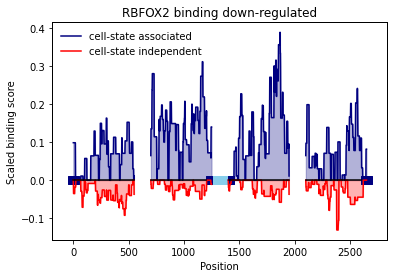

In [36]:
# for rbp in binding.columns:
plot_binding(binding, 'RBFOX2', 
             psix_object.modules.loc[(psix_object.modules>=6) & (psix_object.modules>0)].index, 
             psix_object.psix_results.loc[psix_object.psix_results.qvals >= 0.05].index, 
             pos_label='cell-state associated', neg_label='cell-state independent',
            plot_name = 'down-regulated')

In [251]:
psix_p90 = psix.Psix(psix_object = 'psix_output/psix_object_p90/')

100%|██████████| 2037/2037 [01:29<00:00, 22.64it/s]


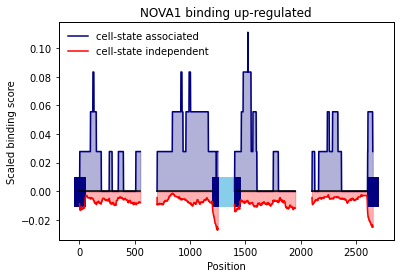

100%|██████████| 2037/2037 [01:29<00:00, 22.75it/s]


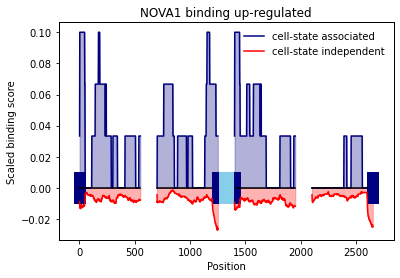

In [268]:
# for rbp in binding.columns:

for i in range(1, 3):
    plot_binding(binding, 'NOVA1', 
                 psix_p90.modules.loc[psix_p90.modules==i].index, 
                 psix_p90.psix_results.loc[psix_p90.psix_results.qvals >= 0.05].index, 
                 pos_label='cell-state associated', neg_label='cell-state independent',
                plot_name = 'up-regulated')

100%|██████████| 2037/2037 [01:11<00:00, 28.55it/s]


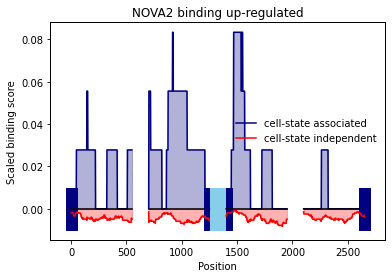

100%|██████████| 2037/2037 [01:17<00:00, 26.43it/s]


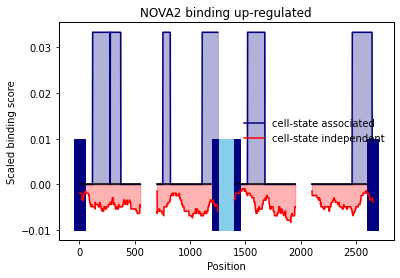

In [271]:
# for rbp in binding.columns:

for i in range(1, 3):
    plot_binding(binding, 'NOVA2', 
                 psix_p90.modules.loc[psix_p90.modules==i].index, 
                 psix_p90.psix_results.loc[psix_p90.psix_results.qvals >= 0.05].index, 
                 pos_label='cell-state associated', neg_label='cell-state independent',
                plot_name = 'up-regulated')

100%|██████████| 2037/2037 [01:29<00:00, 22.65it/s]


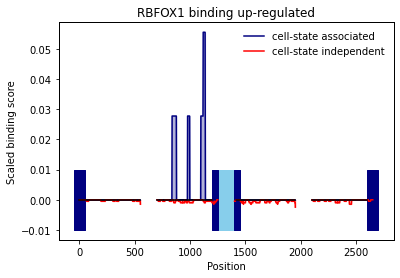

100%|██████████| 2037/2037 [01:20<00:00, 25.31it/s]


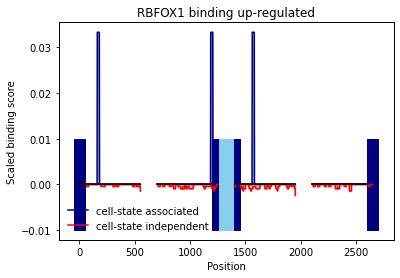

In [269]:
# for rbp in binding.columns:

for i in range(1, 3):
    plot_binding(binding, 'RBFOX1', 
                 psix_p90.modules.loc[psix_p90.modules==i].index, 
                 psix_p90.psix_results.loc[psix_p90.psix_results.qvals >= 0.05].index, 
                 pos_label='cell-state associated', neg_label='cell-state independent',
                plot_name = 'up-regulated')

100%|██████████| 2037/2037 [01:24<00:00, 24.02it/s]


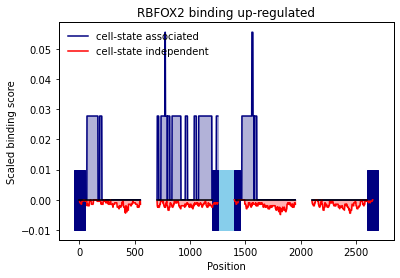

100%|██████████| 2037/2037 [01:16<00:00, 26.49it/s]


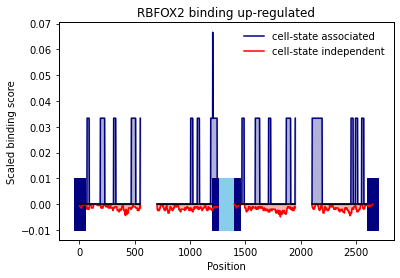

In [270]:
# for rbp in binding.columns:

for i in range(1, 3):
    plot_binding(binding, 'RBFOX2', 
                 psix_p90.modules.loc[psix_p90.modules==i].index, 
                 psix_p90.psix_results.loc[psix_p90.psix_results.qvals >= 0.05].index, 
                 pos_label='cell-state associated', neg_label='cell-state independent',
                plot_name = 'up-regulated')

In [3]:
from statsmodels.stats.multitest import multipletests

tiklova_gearyc = pd.read_csv('gearyc/gearyc.tab.gz', sep='\t', index_col=0)
tiklova_gearyc['qvals'] = multipletests(tiklova_gearyc.pvals, method='fdr_bh')[1]


tiklova_gearyc_test = pd.read_csv('gearyc/gearyc_test.tab.gz', sep='\t', index_col=0)
tiklova_gearyc_test['qvals'] = multipletests(tiklova_gearyc_test.pvals, method='fdr_bh')[1]

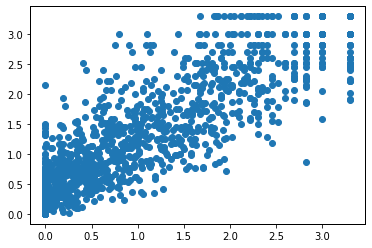

In [7]:
plt.scatter(-np.log10(tiklova_gearyc.pvals), -np.log10(tiklova_gearyc_test.pvals))

In [39]:
tiklova_gearyc_test

,C_score,pvals,qvals
Aamdc_9,0.017588,0.207396,0.304172
Aamdc_10,0.086581,0.010495,0.023653
Aasdhppt_2,0.188720,0.000500,0.001688
Abat_3,0.439328,0.000500,0.001688
Abca3_4,0.025886,0.086457,0.145044
...,...,...,...
Zscan18_1,0.016391,0.349825,0.469508
Zyx_1,0.022521,0.048976,0.089581
l7Rn6_1,0.113082,0.000500,0.001688
l7Rn6_3,-0.019463,0.745627,0.842514


In [40]:
tiklova_gearyc

,C_score,pvals,qvals
Aamdc_9,0.017588,0.207396,0.304172
Aamdc_10,0.086581,0.010495,0.023653
Aasdhppt_2,0.188720,0.000500,0.001688
Abat_3,0.439328,0.000500,0.001688
Abca3_4,0.025886,0.086457,0.145044
...,...,...,...
Zscan18_1,0.016391,0.349825,0.469508
Zyx_1,0.022521,0.048976,0.089581
l7Rn6_1,0.113082,0.000500,0.001688
l7Rn6_3,-0.019463,0.745627,0.842514
